In [4]:
def algoritmo(df2, fecha, show, parcela):
    diasTotales = 365 + 31
    #from IPython.core.display import display, HTML
    #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import datetime

    import warnings
    warnings.filterwarnings("ignore")
    
    borrarDebajo = 0.15
    
    fechas = list()
    fechas2 = list()
    valores = list()
    valores2= list()
    N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

    #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
    #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
    for i in range(N):
        data = df2.iloc[i].fecha
        data = str(data)
        #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
        dt = datetime.datetime.strptime(data, "%Y%m%d")
        dtInt = int(dt.strftime("%j"))
        if int(data) >= 20220000:
            dtInt = dtInt +365
        #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
        #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
        fechas.append(dtInt)
        ndvi = df2.iloc[i].ndvi
        valores.append(ndvi)
        #Solo añado si el valor está por encima de la variable "borrarDebajo"
        if ndvi >= borrarDebajo:
            valores2.append(ndvi)
            fechas2.append(dtInt)

    #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
    #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
    #Si tenemos los valores [3,1,4], borramos el valor 1
    #Borramos los valores valle
    for i in range(len(valores2)-1):
        if i > 0 and i < len(valores2)-1:
            #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
            if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                del valores2[i]
                del fechas2[i]
                del valores2[i]
                del fechas2[i]
            #En el caso de que solo haya un minimo entre 2 puntos
            elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                del valores2[i]
                del fechas2[i]        






    #Variables:
    saltoFechas = 10
    saltoFechas2 = 20
    saltoFechas3 = 30
    añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
    añadirPorEncima = 0.2

    #Añado informacion al principio y final de año si no habia
    if fechas2[0] > 0:
        fechas2.insert(0, 0)
        valores2.insert(0, valores2[0])
    if fechas2[len(fechas2) -1] < diasTotales:
        fechas2.insert(len(fechas2), diasTotales)
        valores2.insert(len(valores2), valores2[len(valores2)-1])


    #Si hay saltos muy grandes sin informacion se trata:
    i = 0
    while i < len(fechas2) - 1: 
        encontrado = False
        #Si el salto es muy grande
        if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
            #buscar maximos locales entre los dos puntos y
            aux1 = 0
            aux2 = 0
            for j in range(len(fechas) - 1):
                if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                    aux1 = j
                elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                    aux2 = j
                    break
            j = aux1 + 1
            auxSum = 0
            while (j < aux2):
                if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                    # y volverlos a añadir segun su valor
                    if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                        fechas2.insert(i+1+ auxSum, fechas[j])
                        valores2.insert(i+1+ auxSum, valores[j])
                        auxSum = auxSum + 1
                        encontrado = True
                j = j + 1



        if encontrado == False:    
            #Si el salto es intermedio
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                if valores2[i+1] > valores2[i]: #va hacia arriba
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                    valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                else: #va hacia abajo
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                    valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
            #Si el salto es pequeño
            elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
        i = i+1


    #Plot    
    from scipy.interpolate import make_interp_spline
    from scipy.interpolate import interp1d

    #Esto crea una linea de <diasTotales> puntos que pasa por todos los puntos que teniamos
    X_Y_Spline = make_interp_spline(fechas2,valores2)        
    X = np.linspace(0, diasTotales, diasTotales)
    Y = X_Y_Spline(X)

    dt = datetime.datetime.strptime(fecha, "%Y%m%d")
    aux = int(dt.strftime("%j"))
    
    if (show):
        plt.figure(figsize=(17,5))
        plt.title('parcela: '+ parcela)
        plt.plot(fechas, valores,'r-')

        plt.xticks(np.arange(0, diasTotales,10))

        plt.plot(X, Y, 'b-')
        plt.scatter(fechas, valores, c=valores, cmap='Set2')

        #Dibujar las lineas verticales asociadas a las fechas de recepcion
        #for recepcion in recepciones:
        #    if recepcion[0] == parcela:
        #        for aux in recepcion[1]:
        #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
        #            aux2 = int(dt.strftime("%j"))
        #            plt.axvline(x=(aux2))  
        #        break

        #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        #aux = int(dt.strftime("%j"))
        plt.axvline(x=(aux))  



        plt.xlabel("X")
        plt.ylabel("Y")
        plt.ylim([0, 1])
        plt.legend(["puntos originales","puntos modificados"])
        plt.show()
        
    return [Y, aux]

def obtenerColumnas():
    columnas = list()
    columnas.append('parcela')
    columnas.append('dia')
    columnas.append('pendiente dia -15')
    columnas.append('pendiente dia -10')
    columnas.append('pendiente dia -5')
    columnas.append('ndvi')
    columnas.append('recogido')
    
    return columnas

def inicializarDataframeIA(columnas):
    import pandas as pd
    df_ia = pd.DataFrame(columns=columnas())
    
    return df_ia

def obtenerParcelasConUnaRecepcion(PARCELASMAIZ20212022CONFECHAS):
    import pandas as pd

    dfFechas = pd.read_csv(PARCELASMAIZ20212022CONFECHAS)
    
    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)
    
    return only_1_reception

def añadirADataframe(parcela, diaDeCarga, valoresDias, columnas, df,diasPendiente, diasMargen):
    import pandas as pd
    for i in range(len(valoresDias)):
        if ((i - (diasPendiente[0])) >= 0 and (i+1) - diaDeCarga > -15 and (i+1) - diaDeCarga <= 5  ):
            
            lista = list()
            lista.append(parcela)
            lista.append(i + 1)
            for j in diasPendiente:
                lista.append((valoresDias[i - j] - valoresDias[i])/j)
                
            lista.append(valoresDias[i])
            if ((diaDeCarga - (i + 1)) <= diasMargen and (diaDeCarga - (i + 1)) >= 0):
                lista.append(1)
            else:
                lista.append(0)

            dfAux = pd.DataFrame([lista], columns=columnas(), index=[len(df)])
            df = df.append(dfAux)
    
    
    return df


def obtenerDatosEntrenables(datosNoEntrenables2122, PARCELASMAIZ20212022CONFECHAS):
    import pandas as pd
    dfFechas = obtenerParcelasConUnaRecepcion(PARCELASMAIZ20212022CONFECHAS)
    
    
    dfDatos = pd.read_csv(datosNoEntrenables2122)
    dfDatos = dfDatos.sort_values(by=["fecha","parcela"], ascending=True)
    
    parcelasQueTengo = dfDatos["parcela"].unique()
    parcelasConUnaRecepcion = dfFechas["PAC"].unique()

    df_ndvi_of_only_1_reception = dfDatos[dfDatos.parcela.isin(dfFechas["PAC"].unique())]
    parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    
    
    df = inicializarDataframeIA(obtenerColumnas)
    i = 0
    j = len(parcelas)
    diaPrimeraRecepcion = [15,10,5]
    diaMargen = 4
    
    
    for parcela in parcelas:

        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = dfFechas.loc[dfFechas["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]
            X, dia_recepcion = algoritmo(df2, fecha, True, parcela)
            if (dia_recepcion > diaPrimeraRecepcion[0]):
                df = añadirADataframe(parcela, dia_recepcion, X, obtenerColumnas, df, diaPrimeraRecepcion, diaMargen)
            i = i + 1
            print(str(i) + "/" + str(j)) 
        else:
            j = j - 1
        

    return df

def separarTrainTest(dataframe):
    parcelas = dataframe['parcela'].unique()
    N = len(parcelas)

    #si hay 2 recintos de la misma zona uno lo meto a test
    test= list()
    train = list(parcelas)
    contador = 1
    for i in range(N):
        parcelaAnterior = parcelas[i - 1].split('_')
        aux = ''
        for j in range(5):
            aux = aux + parcelaAnterior[j] + '_'


        if parcelas[i].startswith(aux):
            test.append(parcelas[i])
            train.remove(parcelas[i])
            if len(test) >= N * 0.1:
                break

    dataframeTrain = dataframe[dataframe['parcela'].isin(train)]
    dataframeTest =  dataframe[dataframe['parcela'].isin(test)]
    
    return [dataframeTrain, dataframeTest]

def obtenerModelo(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu', kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall', threshold = 0.6)])
    model.summary()
    
    return model

def obtenerModelo3(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    #model.add(Dense(n**2, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu',input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

def obtenerModelo4(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu',  kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu', kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall', threshold = 0.6)])
    model.summary()
    
    return model

def obtenerModelo5(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.constraints import MaxNorm
    from tensorflow.keras.optimizers import SGD
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    # Compile model
    #añadir capa
    model.add(Dense(n, activation='relu', input_shape=(n,), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    #
    sgd = SGD(learning_rate=0.1, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=sgd,  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

def obtenerModelo2(dataframeTrain):
    # Perceptron de un solo nivel
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    normalizer = layers.Normalization()
    normalizer.adapt(X) 
    
    model = Sequential()
    
    #model.add(normalizer)
    
    model.add(Dense(4096, kernel_initializer='normal',input_dim = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1], activation='sigmoid'))

    # The Hidden Layers :
    model.add(Dense(2048 ,activation='softmax'))
    model.add(Dense(1024 ,activation='sigmoid'))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(256,activation='softmax'))
    model.add(Dense(128,activation='sigmoid'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='softmax'))
    model.add(Dense(16,activation='sigmoid'))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(4,activation='softmax'))
    
    model.add(Dense(2, activation='softmax'))
    #
    model.compile(loss='categorical_crossentropy', optimizer=Adam(),  metrics=['accuracy'])
    model.summary()
    
    return model

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
    for l in loss_list:
        axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
    axs[0].grid()
    axs[0].legend()
    
    ## Accuracy
    for l in acc_list:
        axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
    axs[1].grid()
    axs[1].legend()
    plt.show()
    
def anyadirUnos(df):
    df['unos'] = [1]*len(df)
    
def RecepcionToBool(recogido):
    aux = np.zeros(2)
    aux[recogido] = 1
    return aux
            
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #plt.tight_layout()

def plot_mnist_confusion_matrix(y_test, y_pred, normalize=False):
    from sklearn.metrics import confusion_matrix
    
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    umbral = 0.01
    
    y_tst = np.zeros(len(y_test))
    for i in range(len(y_test) - 1):
        #if y_test[i][1] >= umbral:
        #    y_tst[i] = 1
        y_tst[i] = np.argmax(y_test[i])
    #y_tst = [np.argmax(y) for y in y_test]
    
    y_prd = np.zeros(len(y_pred))
    for i in range(len(y_pred) - 1):
        #if y_pred[i][1] >= umbral:
        #    y_prd[i] = 1
        y_prd[i] = np.argmax(y_pred[i])
    #y_prd = [np.argmax(y) for y in y_pred]

    cnf_matrix = confusion_matrix(y_tst, y_prd)
    
    yprueba = list()
    for y in y_tst:
        yprueba.append(y)
    for y in y_prd:
        yprueba.append(y)
    class_names=np.unique(yprueba)
    print(class_names)
    plt.figure(figsize=(20,20))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          normalize=normalize)
    
def quitarDatosMalos(df):
    #QUITA LAS PARCELAS QUE NO TENGAN 20 DIAS DE DATOS
    parcelasAQuitar = list()
    parcelas = df['parcela'].unique()
    for parcela in parcelas:
        if len(df.loc[df['parcela'] == parcela]) != 20:
            parcelasAQuitar.append(parcela)
    
    df = df[~df['parcela'].isin(parcelasAQuitar)]
    return df
    
def anyadirRelacionesParametros2(df):
    columnas = df.shape[1]
    for i in range(columnas):
        for j in range(columnas):
            if i < j:
                nombreColumna = 'col ' + str(i+1) + ' * col ' + str(j+1)
                df[nombreColumna] = df.iloc[:,i] * df.iloc[:,j]
                
    return df
    
def anyadirRelacionesParametros(df, listaColumnas = ['parcela','dia','recogido','ndvi']):
    aux = pd.DataFrame()
    for i in listaColumnas:
        aux[i] = df[i]
        df = df.drop(columns=[i])
        
    df = anyadirRelacionesParametros2(df)
    for i in listaColumnas:
        df[i] = aux[i]
    return df
    
def entrenarModelo(model, dataframeTrain, dataframeTest, batch_size, epochs, callbacks_list):
    def RecepcionToBool(recogido):
        aux = np.zeros(2)
        aux[recogido] = 1
        return aux

    #DATA TRAINING   
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    N = len(dataframeTrain)


    verbose = True
    t0 = time.perf_counter()
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    y = np.asarray(dataframeTrain[["recogido"]]).astype(np.float32)
    
    #DATA TESTING
    N = len(dataframeTest)

    Xtest = np.asarray(dataframeTest.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    ytest = np.asarray(dataframeTest[["recogido"]]).astype(np.float32)
    


    history = model.fit(X, y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=False, 
                        callbacks=callbacks_list,
                       validation_data=(Xtest,ytest))

    #model.predict(X_cv)

    train_time = time.perf_counter() - t0
    print('%s %.3f%s' %  ('Training time: ', train_time, 's') )
    plot_history(history)
    
def predecirYMostrarMatrizConfusion(df,model,pesos, umbral = 0.6):
    df = df.reset_index()
    df = df.drop(columns=['index'])
    X = df.drop(columns=['parcela','dia','recogido'])
    y = df['recogido']
    
    X=np.asarray(X).astype(np.float)

    y=np.asarray(y).astype(np.float)
    
    model.load_weights(pesos)
    
    
    
    y_pred = model.predict(X, verbose=True)
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(y_pred)):
        if y_pred[i] >= umbral and y[i] == 1:
            tp = tp + 1
        elif y_pred[i] >= umbral and y[i] == 0:
            fp = fp + 1
        elif y_pred[i] < umbral and y[i] == 1:
            fn = fn + 1
        else:
            tn = tn + 1


    test_score = (tp + tn)/ len(X)
    print('%s %2.2f%s' % ('Accuracy test:  ', 100*test_score, '%'))

    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    ind = np.asarray([0.0,1.0]).astype(np.float32)
    mat = np.asarray([[tn, fp], [fn, tp]]).astype(np.int32)
    plt.figure(figsize=(20,20))
    plot_confusion_matrix(mat, classes=ind,
                              normalize=False)



# Define la función de poda
def prune_low_weights(model, pruning_threshold):
    from keras import backend as K
    for layer in model.layers:
        if hasattr(layer, 'kernel_regularizer'):
            weights = layer.get_weights()[0]  # Obtiene los pesos de la capa
            mask = K.abs(weights) > pruning_threshold  # Aplica el umbral
            weights *= mask  # Poda los pesos por debajo del umbral
            layer.set_weights([weights])  # Establece los pesos podados en la capa
            
def parcelasConAciertos(dataframe,model,  umbral = 0.6):
    dataframeRecogidoUno = dataframe.loc[dataframe['recogido'] == 1]
    parcelasAObservar = dataframe['parcela'].unique()
    parcelasSinResultado = list(dataframe['parcela'].unique())
    print(len(parcelasSinResultado))
    print("hay ", str(len(parcelasAObservar)), " parcelas a observar")
    print('------------------')
    cantidad = 0
    for parcela in parcelasAObservar:
        unoAcertado = False
        datos = dataframe.loc[dataframe['parcela'] == parcela]
        dias = dataframeRecogidoUno.loc[dataframeRecogidoUno['parcela'] == parcela]['dia']
        print(parcela, 'dias que deberia dar 1 la prediccion:')
        print(dias)
        Xtest = np.asarray(dataframe.loc[dataframe['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
        ytest = np.asarray(dataframe.loc[dataframe['parcela'] == parcela][["recogido"]]).astype(np.float32)
        ypred = model.predict(Xtest, verbose=0)
        print("dias que ha dado 1 la prediccion: ")
        for i in range(len(ypred)):
            if ypred[i] >= umbral:
                print('dia: ', datos.iloc[i]['dia'])
                if ytest[i] == 1 and unoAcertado == False:
                    cantidad = cantidad + 1
                    unoAcertado = True
                    
                    
        if (unoAcertado == True):
            print("ha acertado por lo menos un 1 de los que deberia")
            parcelasSinResultado.remove(parcela)

        print('------------------')

    print('Parcelas con acierto: ',cantidad, "de", str(len(parcelasAObservar)))
    return [parcelasAObservar, parcelasSinResultado]
    
def obtenerMejorModelo(directory_init = ''):
    import os
    import ipynbname
    if directory_init == '':
        directory = ipynbname.name()
    else:
        directory = directory_init
    baccuracyMax = 0
    baccuracyMaxFile = ''
    val_baccuracyMax = 0
    val_baccuracyMaxFile = ''
    recallMax = 0
    recallMaxFile = ''
    val_recallMax = 0
    val_recallMaxFile = ''
    # iterate over files in
    # that directory
    for subdirectory in os.listdir(directory):
        f = os.path.join(directory, subdirectory)
        # checking if it is a file
        for filename in os.listdir(f):
            campos = filename.split('-')
            f1 = os.path.join(f, filename)
            if (len(campos)) == 5:
                if (campos[3] == 'binary_accuracy' and float(campos[4][:len(campos[4])-5]) > float(baccuracyMax)):
                    baccuracyMax = float(campos[4][:len(campos[4])-5])
                    baccuracyMaxFile = f1
                if (campos[3] == 'val_binary_accuracy' and float(campos[4][:len(campos[4])-5]) > float(val_baccuracyMax)):
                    val_baccuracyMax = float(campos[4][:len(campos[4])-5])
                    val_baccuracyMaxFile = f1
                if (campos[3] == 'recall' and float(campos[4][:len(campos[4])-5]) > float(recallMax)):
                    recallMax = float(campos[4][:len(campos[4])-5])
                    recallMaxFile = f1
                if (campos[3] == 'val_recall' and float(campos[4][:len(campos[4])-5]) > float(val_recallMax)):
                    val_recallMax = float(campos[4][:len(campos[4])-5])
                    val_recallMaxFile = f1

    print("Mejor binary_accuracy: ", baccuracyMax)
    print(baccuracyMaxFile)
    print("Mejor val_binary_accuracy: ", val_baccuracyMax)
    print(val_baccuracyMaxFile)
    print("Mejor recall: ", recallMax)
    print(recallMaxFile)
    print("Mejor val_recall: ", val_recallMax)
    print(val_recallMaxFile)


In [5]:
def mostrarParcelasSinAciertos(parcelasAObservar):

    def algoritmo(df2, fecha, show, tp, fp):

        #from IPython.core.display import display, HTML
        #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        import datetime

        import warnings
        warnings.filterwarnings("ignore")

        borrarDebajo = 0.15

        fechas = list()
        fechas2 = list()
        valores = list()
        valores2= list()
        N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

        #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
        #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
        for i in range(N):
            data = df2.iloc[i].fecha
            data = str(data)
            #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
            dt = datetime.datetime.strptime(data, "%Y%m%d")
            #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
            #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
            fechas.append(int(dt.strftime("%j")))
            ndvi = df2.iloc[i].ndvi
            valores.append(ndvi)
            #Solo añado si el valor está por encima de la variable "borrarDebajo"
            if ndvi >= borrarDebajo:
                valores2.append(ndvi)
                fechas2.append(int(dt.strftime("%j")))

        #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
        #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
        #Si tenemos los valores [3,1,4], borramos el valor 1
        #Borramos los valores valle
        for i in range(len(valores2)-1):
            if i > 0 and i < len(valores2)-1:
                #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
                if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                    del valores2[i]
                    del fechas2[i]
                    del valores2[i]
                    del fechas2[i]
                #En el caso de que solo haya un minimo entre 2 puntos
                elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                    del valores2[i]
                    del fechas2[i]        






        #Variables:
        saltoFechas = 10
        saltoFechas2 = 20
        saltoFechas3 = 30
        añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
        añadirPorEncima = 0.2

        #Añado informacion al principio y final de año si no habia
        if fechas2[0] > 0:
            fechas2.insert(0, 0)
            valores2.insert(0, valores2[0])
        if fechas2[len(fechas2) -1] < 365:
            fechas2.insert(len(fechas2), 365)
            valores2.insert(len(valores2), valores2[len(valores2)-1])


        #Si hay saltos muy grandes sin informacion se trata:
        i = 0
        while i < len(fechas2) - 1: 
            encontrado = False
            #Si el salto es muy grande
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
                #buscar maximos locales entre los dos puntos y
                aux1 = 0
                aux2 = 0
                for j in range(len(fechas) - 1):
                    if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                        aux1 = j
                    elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                        aux2 = j
                        break
                j = aux1 + 1
                auxSum = 0
                while (j < aux2):
                    if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                        # y volverlos a añadir segun su valor
                        if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                            fechas2.insert(i+1+ auxSum, fechas[j])
                            valores2.insert(i+1+ auxSum, valores[j])
                            auxSum = auxSum + 1
                            encontrado = True
                    j = j + 1



            if encontrado == False:    
                #Si el salto es intermedio
                if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                    if valores2[i+1] > valores2[i]: #va hacia arriba
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                        valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                    else: #va hacia abajo
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                        valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
                #Si el salto es pequeño
                elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                    fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                    valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
            i = i+1


        #Plot    
        from scipy.interpolate import make_interp_spline
        from scipy.interpolate import interp1d

        #Esto crea una linea de 365 puntos que pasa por todos los puntos que teniamos
        X_Y_Spline = make_interp_spline(fechas2,valores2)        
        X = np.linspace(0, 365, 365)
        Y = X_Y_Spline(X)

        dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        aux = int(dt.strftime("%j"))

        if (show):
            plt.figure(figsize=(17,5))
            plt.title('parcela: '+ parcela)
            plt.plot(fechas, valores,'r-')

            plt.xticks(np.arange(0, 365,10))

            plt.plot(X, Y, 'b-')
            plt.scatter(fechas, valores, c=valores, cmap='Set2')

            #Dibujar las lineas verticales asociadas a las fechas de recepcion
            #for recepcion in recepciones:
            #    if recepcion[0] == parcela:
            #        for aux in recepcion[1]:
            #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
            #            aux2 = int(dt.strftime("%j"))
            #            plt.axvline(x=(aux2))  
            #        break

            #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
            #aux = int(dt.strftime("%j"))
            plt.axvline(x=(aux), linewidth=2, color='black') 
            [plt.axvline(_x, linewidth=1, color='r') for _x in fp]
            [plt.axvline(_x, linewidth=1, color='g') for _x in tp]







            plt.xlabel("X")
            plt.ylabel("Y")
            plt.ylim([0, 1])
            plt.legend(["puntos originales","puntos modificados","recepcion", "falsos positivo"])
            plt.show()

        return [Y, aux]

    import pandas as pd
    import numpy as np

    dfFechas = pd.read_csv('PARCELAS-MAIZ-2021-2022-CON-FECHAS.csv')

    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)

    df = pd.read_csv('TODOSLOSRECINTOS.csv')

    #Ordeno por fecha y parcela
    sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)
    sorted_df = sorted_df.drop(columns=['Unnamed: 0'])
    parcelasQueTengo = sorted_df["parcela"].unique()
    parcelasConUnaRecepcion = only_1_reception["PAC"].unique()

    df_ndvi_of_only_1_reception = sorted_df[sorted_df.parcela.isin(only_1_reception["PAC"].unique())]

    dias1 = 7
    dias2 = 180


    i = 0
    #parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    parcelas = parcelasAObservar
    for parcela in parcelas:
        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = only_1_reception.loc[only_1_reception["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]

            datos = dataframeAux.loc[dataframeAux['parcela'] == parcela]
            dias = dataframeDias.loc[dataframeDias['parcela'] == parcela]['dia']
            #print('------------------')
            #print(parcela, 'dias:')
            tp = list(dias)
            #print(dias)
            Xtest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
            ytest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela][["recogido"]]).astype(np.float32)
            ypred = model.predict(Xtest, verbose=0)
            fp = list()
            for i in range(len(ypred)):
                if ypred[i] >= 0.6:
                    fp.append(datos.iloc[i]['dia'])


            X, dia_recepcion = algoritmo(df2, fecha, True, tp, fp)

            i = i + 1





def mostrarParcelasConAciertos(parcelasAObservar):
    def intersection(lst1, lst2):
                lst3 = [value for value in lst1 if value in lst2]
                return lst3
    def algoritmo(df2, fecha, show, tp, fp):

        #from IPython.core.display import display, HTML
        #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        import datetime

        import warnings
        warnings.filterwarnings("ignore")

        borrarDebajo = 0.15

        fechas = list()
        fechas2 = list()
        valores = list()
        valores2= list()
        N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

        #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
        #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
        for i in range(N):
            data = df2.iloc[i].fecha
            data = str(data)
            #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
            dt = datetime.datetime.strptime(data, "%Y%m%d")
            #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
            #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
            fechas.append(int(dt.strftime("%j")))
            ndvi = df2.iloc[i].ndvi
            valores.append(ndvi)
            #Solo añado si el valor está por encima de la variable "borrarDebajo"
            if ndvi >= borrarDebajo:
                valores2.append(ndvi)
                fechas2.append(int(dt.strftime("%j")))

        #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
        #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
        #Si tenemos los valores [3,1,4], borramos el valor 1
        #Borramos los valores valle
        for i in range(len(valores2)-1):
            if i > 0 and i < len(valores2)-1:
                #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
                if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                    del valores2[i]
                    del fechas2[i]
                    del valores2[i]
                    del fechas2[i]
                #En el caso de que solo haya un minimo entre 2 puntos
                elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                    del valores2[i]
                    del fechas2[i]        






        #Variables:
        saltoFechas = 10
        saltoFechas2 = 20
        saltoFechas3 = 30
        añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
        añadirPorEncima = 0.2

        #Añado informacion al principio y final de año si no habia
        if fechas2[0] > 0:
            fechas2.insert(0, 0)
            valores2.insert(0, valores2[0])
        if fechas2[len(fechas2) -1] < 365:
            fechas2.insert(len(fechas2), 365)
            valores2.insert(len(valores2), valores2[len(valores2)-1])


        #Si hay saltos muy grandes sin informacion se trata:
        i = 0
        while i < len(fechas2) - 1: 
            encontrado = False
            #Si el salto es muy grande
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
                #buscar maximos locales entre los dos puntos y
                aux1 = 0
                aux2 = 0
                for j in range(len(fechas) - 1):
                    if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                        aux1 = j
                    elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                        aux2 = j
                        break
                j = aux1 + 1
                auxSum = 0
                while (j < aux2):
                    if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                        # y volverlos a añadir segun su valor
                        if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                            fechas2.insert(i+1+ auxSum, fechas[j])
                            valores2.insert(i+1+ auxSum, valores[j])
                            auxSum = auxSum + 1
                            encontrado = True
                    j = j + 1



            if encontrado == False:    
                #Si el salto es intermedio
                if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                    if valores2[i+1] > valores2[i]: #va hacia arriba
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                        valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                    else: #va hacia abajo
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                        valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
                #Si el salto es pequeño
                elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                    fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                    valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
            i = i+1


        #Plot    
        from scipy.interpolate import make_interp_spline
        from scipy.interpolate import interp1d

        #Esto crea una linea de 365 puntos que pasa por todos los puntos que teniamos
        X_Y_Spline = make_interp_spline(fechas2,valores2)        
        X = np.linspace(0, 365, 365)
        Y = X_Y_Spline(X)

        dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        aux = int(dt.strftime("%j"))

        if (show):
            plt.figure(figsize=(17,5))
            plt.title('parcela: '+ parcela)
            plt.plot(fechas, valores,'r-')

            plt.xticks(np.arange(0, 365,10))

            plt.plot(X, Y, 'b-')
            plt.scatter(fechas, valores, c=valores, cmap='Set2')

            #Dibujar las lineas verticales asociadas a las fechas de recepcion
            #for recepcion in recepciones:
            #    if recepcion[0] == parcela:
            #        for aux in recepcion[1]:
            #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
            #            aux2 = int(dt.strftime("%j"))
            #            plt.axvline(x=(aux2))  
            #        break

            #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
            #aux = int(dt.strftime("%j"))
            plt.axvline(x=(aux), linewidth=2, color='black') 
            print('dia de recepcion: ',aux)
            interseccion = intersection(tp,fp)
            print('true positives: ', interseccion)


            [plt.axvline(_x, linewidth=1, color='orange') for _x in interseccion]

            if len(interseccion) > 0:
                for i in interseccion:
                    tp.remove(i)
                    fp.remove(i)
            [plt.axvline(_x, linewidth=1, color='g') for _x in tp]
            [plt.axvline(_x, linewidth=1, color='r') for _x in fp]





            plt.xlabel("X")
            plt.ylabel("Y")
            plt.ylim([0, 1])
            plt.legend(["puntos originales","puntos modificados","recepcion"])
            plt.show()

        return [Y, aux]

    import pandas as pd
    import numpy as np

    dfFechas = pd.read_csv('PARCELAS-MAIZ-2021-2022-CON-FECHAS.csv')

    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)

    df = pd.read_csv('TODOSLOSRECINTOS.csv')

    #Ordeno por fecha y parcela
    sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)
    sorted_df = sorted_df.drop(columns=['Unnamed: 0'])
    parcelasQueTengo = sorted_df["parcela"].unique()
    parcelasConUnaRecepcion = only_1_reception["PAC"].unique()

    df_ndvi_of_only_1_reception = sorted_df[sorted_df.parcela.isin(only_1_reception["PAC"].unique())]

    dias1 = 7
    dias2 = 180


    i = 0
    #parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    dataframeAux = dataframeTest
    parcelas = dataframeAux['parcela'].unique()
    for parcela in parcelas:
        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = only_1_reception.loc[only_1_reception["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]

            datos = dataframeAux.loc[dataframeAux['parcela'] == parcela]
            dias = dataframeDias.loc[dataframeDias['parcela'] == parcela]['dia']
            #print('------------------')
            #print(parcela, 'dias:')
            tp = list(dias)
            #print(dias)
            Xtest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
            ytest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela][["recogido"]]).astype(np.float32)
            ypred = model.predict(Xtest, verbose=0)
            fp = list()
            #print(len(ypred))
            for i in range(len(ypred)):
                if ypred[i] >= 0.6:
                    fp.append(datos.iloc[i]['dia'])

            #print(tp, fp)
            if len(intersection(tp, fp)) > 0:
                X, dia_recepcion = algoritmo(df2, fecha, True, tp, fp)


            i = i + 1




El modelo de red neuronal:

In [6]:
def obtenerModelo20230110(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    #X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    #normalizer = layers.Normalization()
    #normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    #model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu', input_shape=(n,) ))
    model.add(Dense(n, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

La funcion de exito:

In [7]:
def funcionExito(ypred, dia, diaRecogida):
    import math
    if  abs(dia - diaRecogida) == 0:
        return ypred
    else: 
        return ypred / (1 + math.log(1 + abs(dia - diaRecogida),10))


def exito(dataframeTest, funcionExito):
    promedio = 0
    maxexito = 0
    minexito = 9999
    for parcela in dataframeTest['parcela'].unique():
        maximo = 0
        X = dataframeTest.loc[dataframeTest['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])
        X=np.asarray(X).astype(np.float)
        #print(dataframeTest.loc[dataframeTest['parcela'] == "22_27_0_1_503_5019_1"])
        ypred = model.predict(X)
        dias = dataframeTest.loc[dataframeTest['parcela'] == parcela]['dia']
        diaRecogida = dataframeTest.loc[dataframeTest['parcela'] == parcela].iloc[14]['dia']

        #print("--------")
        #print(dias.iloc[1])
        #print(res[0])
        for i in range(len(ypred)):
            #print("--------")
            #print(ypred[i])
            valorExito = funcionExito(ypred[i], dias.iloc[i], diaRecogida)
            
            if valorExito > maximo:
                maximo = valorExito
                print(parcela, ypred[i], maximo, dias.iloc[i] - diaRecogida)

        print(maximo)
        promedio = promedio + maximo
        if maximo < minexito:
            minexito = maximo
        if maximo > maxexito:
            maxexito = maximo
        
    return [minexito, maxexito, promedio/len(dataframeTest['parcela'].unique())]
            

In [277]:
def mostrarCurvaRoc(y_train, y_train_pred, y_test, y_test_pred):
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt

    # Suponiendo que 'y_train_true' y 'y_train_pred_prob' son los valores verdaderos y las probabilidades predichas para el conjunto de entrenamiento
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_pred)

    # Suponiendo que 'y_test_true' y 'y_test_pred_prob' son los valores verdaderos y las probabilidades predichas para el conjunto de prueba
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    # Graficar las curvas ROC de entrenamiento y prueba en el mismo gráfico
    plt.plot(fpr_train, tpr_train, color='orange', label='Train AUC = {:.2f}'.format(auc_train))
    plt.plot(fpr_test, tpr_test, color='blue', label='Test AUC = {:.2f}'.format(auc_test))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()
    plt.show()

Voy a repetir las pruebas del fichero 'TemperaturaPrecipitacionSinNdvi-20230110.ipynb' pero usando la libreria Smote para arreglar el undersampling de los datos etiquetados a 1 ya que son 1/4 del total.

In [290]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=1)

df = pd.read_csv('datosEntrenables20230131-full.csv')
parcelasAQuitar = df.loc[df['estacion'] == 'not inialized']['parcela'].unique()
df = df[~df['parcela'].isin(parcelasAQuitar)]
df = df.drop(columns=['Unnamed: 0','precSum3','estacion'])
df = quitarDatosMalos(df)
X_resampled,y_resampled = smote.fit_resample(df.drop(columns=['recogido','parcela','dia']), df['recogido'])
X_resampled = anyadirRelacionesParametros(X_resampled, ['tmed','prec','ndvi'])
anyadirUnos(X_resampled)

He añadido el doble de datos marcados con 1 para tener la misma cantidad de cada clase

Pruebo con una classificacion sencilla con kcross-validation:

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1138
           1       0.83      0.84      0.83      1166

    accuracy                           0.83      2304
   macro avg       0.83      0.83      0.83      2304
weighted avg       0.83      0.83      0.83      2304



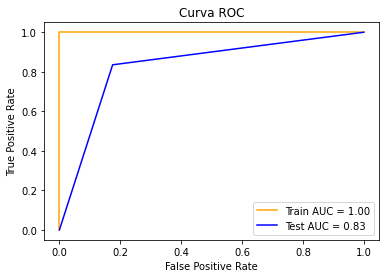

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1143
           1       0.82      0.85      0.84      1161

    accuracy                           0.83      2304
   macro avg       0.83      0.83      0.83      2304
weighted avg       0.83      0.83      0.83      2304



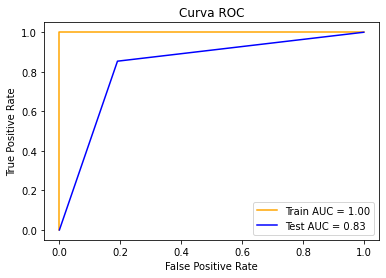

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1180
           1       0.79      0.85      0.82      1124

    accuracy                           0.82      2304
   macro avg       0.82      0.82      0.82      2304
weighted avg       0.82      0.82      0.82      2304



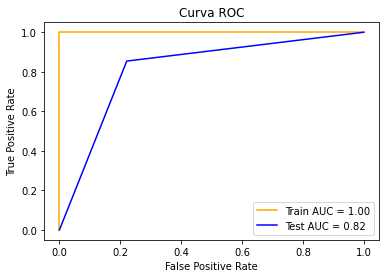

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1168
           1       0.82      0.84      0.83      1136

    accuracy                           0.83      2304
   macro avg       0.83      0.83      0.83      2304
weighted avg       0.83      0.83      0.83      2304



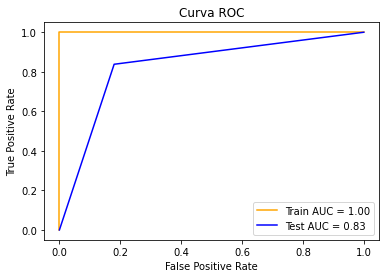

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1131
           1       0.81      0.83      0.82      1173

    accuracy                           0.81      2304
   macro avg       0.81      0.81      0.81      2304
weighted avg       0.81      0.81      0.81      2304



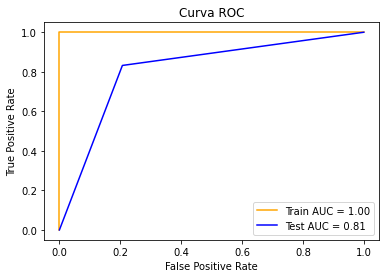

In [291]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
import random
random.seed(42)
X = X_resampled
y = y_resampled

kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier()

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
    report = classification_report(y_test, y_pred)

    # Imprimir el informe de clasificación
    print(report)

    y_train_pred = model.predict(X_train)
    mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)

Este modelo muy simple (RandomForestClassification) funciona bastante bien. Buenos resultados. Scores alrededor de 0.8 ya habia obtenido antes pero con los datos desequilibrados, por lo que con que acertase la clase mayoritaria facilmente tenia este score. Ahora con los datos equilibrados estos scores tienen mas merito. Recalls y precisiones de 0.8 no habia obtenido anteriormente asi que son muy buenos resultados.

Voy a repetirlo pero usando mas tipos de modelos simples como los que se encuentran en la variable 'models':

Model: SVC
              precision    recall  f1-score   support

           0       0.65      0.17      0.27      1138
           1       0.53      0.91      0.67      1166

    accuracy                           0.54      2304
   macro avg       0.59      0.54      0.47      2304
weighted avg       0.59      0.54      0.47      2304



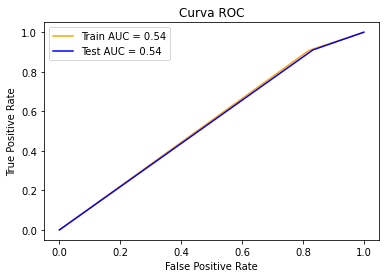

              precision    recall  f1-score   support

           0       0.66      0.18      0.28      1143
           1       0.53      0.91      0.67      1161

    accuracy                           0.55      2304
   macro avg       0.59      0.54      0.48      2304
weighted avg       0.59      0.55      0.48      2304



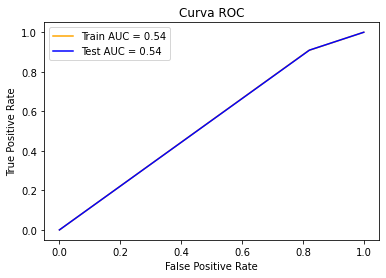

              precision    recall  f1-score   support

           0       0.67      0.19      0.30      1180
           1       0.51      0.90      0.65      1124

    accuracy                           0.54      2304
   macro avg       0.59      0.55      0.48      2304
weighted avg       0.59      0.54      0.47      2304



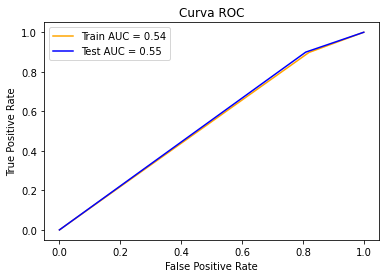

              precision    recall  f1-score   support

           0       0.68      0.16      0.26      1168
           1       0.52      0.92      0.66      1136

    accuracy                           0.54      2304
   macro avg       0.60      0.54      0.46      2304
weighted avg       0.60      0.54      0.46      2304



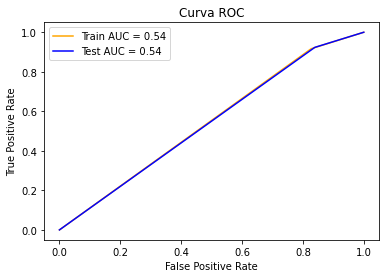

              precision    recall  f1-score   support

           0       0.63      0.18      0.29      1131
           1       0.53      0.89      0.67      1173

    accuracy                           0.55      2304
   macro avg       0.58      0.54      0.48      2304
weighted avg       0.58      0.55      0.48      2304



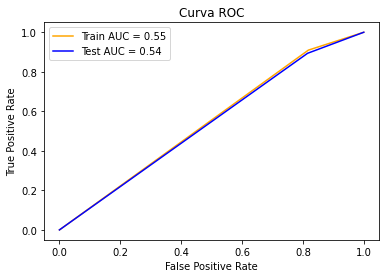

Model: GaussianNB
              precision    recall  f1-score   support

           0       0.58      0.23      0.33      1138
           1       0.53      0.83      0.65      1166

    accuracy                           0.54      2304
   macro avg       0.55      0.53      0.49      2304
weighted avg       0.55      0.54      0.49      2304



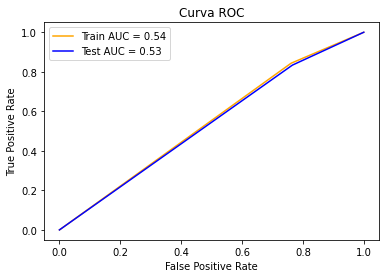

              precision    recall  f1-score   support

           0       0.59      0.23      0.33      1143
           1       0.53      0.85      0.65      1161

    accuracy                           0.54      2304
   macro avg       0.56      0.54      0.49      2304
weighted avg       0.56      0.54      0.49      2304



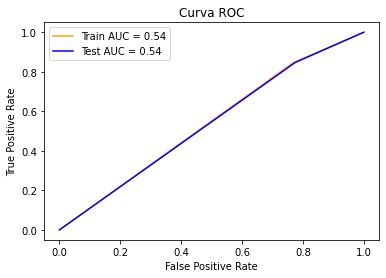

              precision    recall  f1-score   support

           0       0.62      0.25      0.35      1180
           1       0.52      0.84      0.64      1124

    accuracy                           0.54      2304
   macro avg       0.57      0.54      0.50      2304
weighted avg       0.57      0.54      0.49      2304



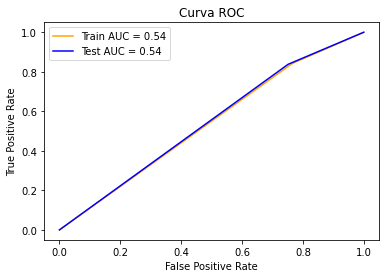

              precision    recall  f1-score   support

           0       0.62      0.23      0.34      1168
           1       0.52      0.85      0.65      1136

    accuracy                           0.54      2304
   macro avg       0.57      0.54      0.49      2304
weighted avg       0.57      0.54      0.49      2304



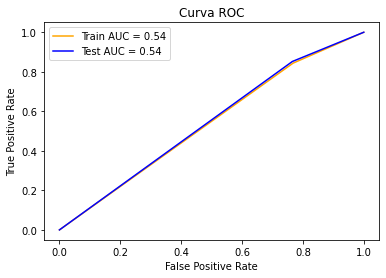

              precision    recall  f1-score   support

           0       0.59      0.23      0.33      1131
           1       0.53      0.85      0.65      1173

    accuracy                           0.54      2304
   macro avg       0.56      0.54      0.49      2304
weighted avg       0.56      0.54      0.49      2304



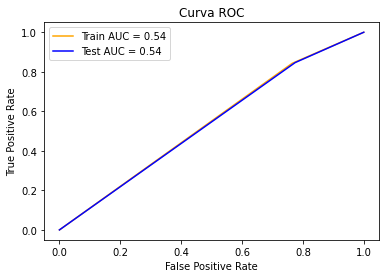

Model: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1138
           1       0.76      0.84      0.80      1166

    accuracy                           0.78      2304
   macro avg       0.79      0.78      0.78      2304
weighted avg       0.79      0.78      0.78      2304



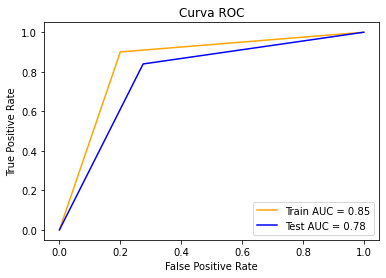

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1143
           1       0.77      0.84      0.80      1161

    accuracy                           0.79      2304
   macro avg       0.79      0.79      0.79      2304
weighted avg       0.79      0.79      0.79      2304



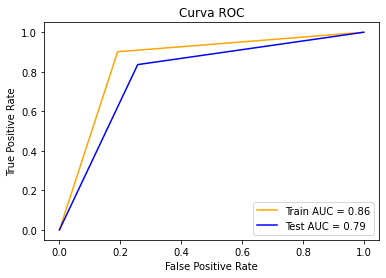

              precision    recall  f1-score   support

           0       0.83      0.68      0.75      1180
           1       0.72      0.86      0.78      1124

    accuracy                           0.77      2304
   macro avg       0.78      0.77      0.77      2304
weighted avg       0.78      0.77      0.77      2304



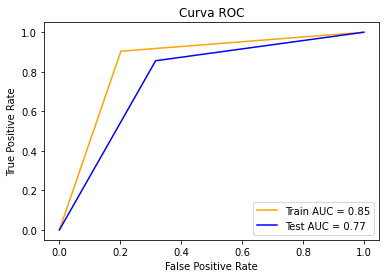

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1168
           1       0.76      0.83      0.79      1136

    accuracy                           0.79      2304
   macro avg       0.79      0.79      0.79      2304
weighted avg       0.79      0.79      0.79      2304



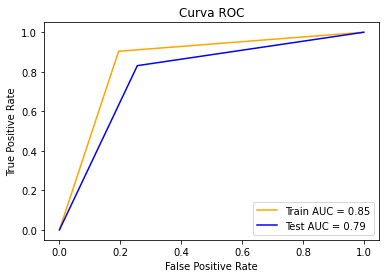

              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1131
           1       0.75      0.84      0.79      1173

    accuracy                           0.78      2304
   macro avg       0.78      0.78      0.78      2304
weighted avg       0.78      0.78      0.78      2304



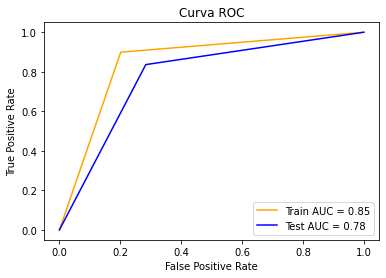

Model: GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.73      0.62      0.67      1138
           1       0.68      0.77      0.72      1166

    accuracy                           0.70      2304
   macro avg       0.70      0.70      0.70      2304
weighted avg       0.70      0.70      0.70      2304



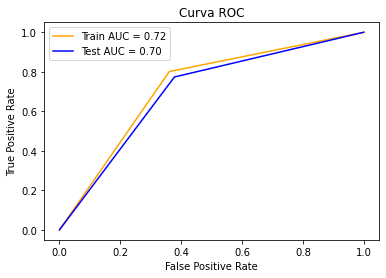

              precision    recall  f1-score   support

           0       0.74      0.62      0.68      1143
           1       0.68      0.79      0.73      1161

    accuracy                           0.71      2304
   macro avg       0.71      0.71      0.70      2304
weighted avg       0.71      0.71      0.70      2304



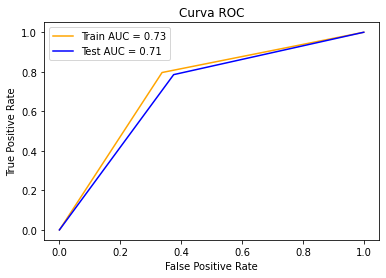

              precision    recall  f1-score   support

           0       0.74      0.58      0.65      1180
           1       0.64      0.79      0.71      1124

    accuracy                           0.68      2304
   macro avg       0.69      0.68      0.68      2304
weighted avg       0.69      0.68      0.68      2304



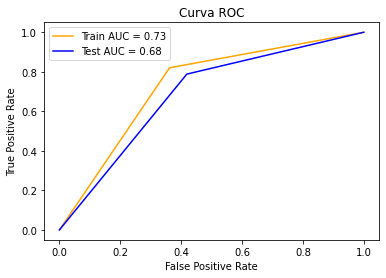

              precision    recall  f1-score   support

           0       0.74      0.63      0.68      1168
           1       0.67      0.77      0.72      1136

    accuracy                           0.70      2304
   macro avg       0.71      0.70      0.70      2304
weighted avg       0.71      0.70      0.70      2304



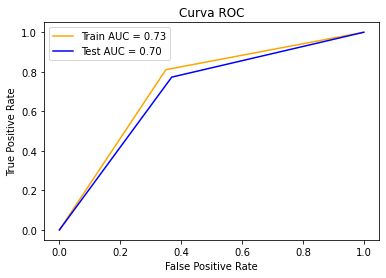

              precision    recall  f1-score   support

           0       0.72      0.62      0.66      1131
           1       0.68      0.76      0.72      1173

    accuracy                           0.69      2304
   macro avg       0.70      0.69      0.69      2304
weighted avg       0.69      0.69      0.69      2304



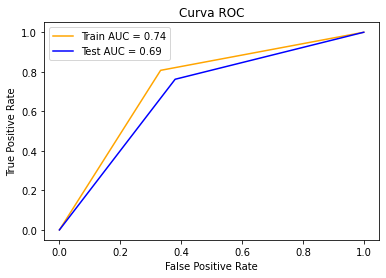

Model: AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.66      0.59      0.62      1138
           1       0.64      0.71      0.67      1166

    accuracy                           0.65      2304
   macro avg       0.65      0.65      0.65      2304
weighted avg       0.65      0.65      0.65      2304



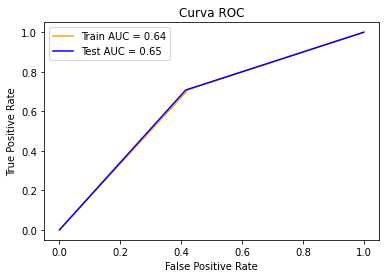

              precision    recall  f1-score   support

           0       0.63      0.52      0.57      1143
           1       0.60      0.70      0.64      1161

    accuracy                           0.61      2304
   macro avg       0.61      0.61      0.61      2304
weighted avg       0.61      0.61      0.61      2304



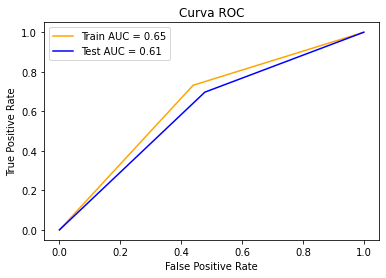

              precision    recall  f1-score   support

           0       0.65      0.53      0.58      1180
           1       0.59      0.70      0.64      1124

    accuracy                           0.61      2304
   macro avg       0.62      0.62      0.61      2304
weighted avg       0.62      0.61      0.61      2304



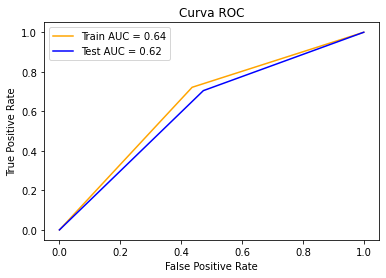

              precision    recall  f1-score   support

           0       0.69      0.50      0.58      1168
           1       0.60      0.77      0.67      1136

    accuracy                           0.63      2304
   macro avg       0.64      0.63      0.63      2304
weighted avg       0.64      0.63      0.63      2304



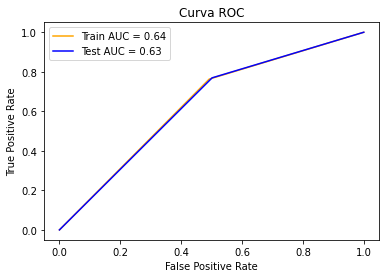

              precision    recall  f1-score   support

           0       0.62      0.56      0.59      1131
           1       0.61      0.66      0.64      1173

    accuracy                           0.61      2304
   macro avg       0.61      0.61      0.61      2304
weighted avg       0.61      0.61      0.61      2304



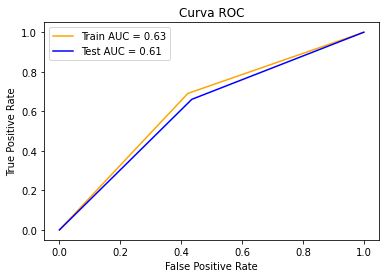

Model: MLPClassifier
              precision    recall  f1-score   support

           0       0.58      0.37      0.45      1138
           1       0.55      0.75      0.63      1166

    accuracy                           0.56      2304
   macro avg       0.57      0.56      0.54      2304
weighted avg       0.57      0.56      0.54      2304



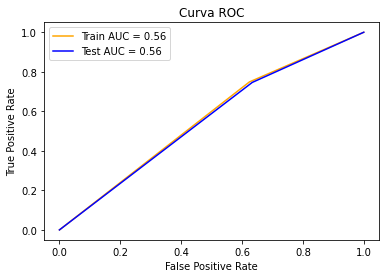

              precision    recall  f1-score   support

           0       0.62      0.30      0.41      1143
           1       0.54      0.82      0.65      1161

    accuracy                           0.56      2304
   macro avg       0.58      0.56      0.53      2304
weighted avg       0.58      0.56      0.53      2304



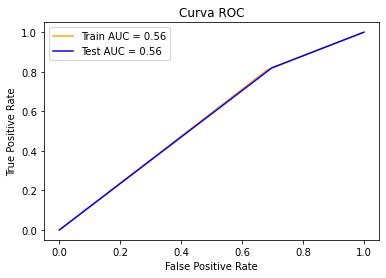

              precision    recall  f1-score   support

           0       0.61      0.49      0.54      1180
           1       0.55      0.67      0.61      1124

    accuracy                           0.58      2304
   macro avg       0.58      0.58      0.57      2304
weighted avg       0.58      0.58      0.57      2304



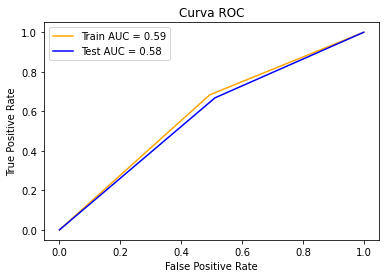

D:\Uni\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.62      0.47      0.54      1168
           1       0.57      0.71      0.63      1136

    accuracy                           0.59      2304
   macro avg       0.59      0.59      0.58      2304
weighted avg       0.59      0.59      0.58      2304



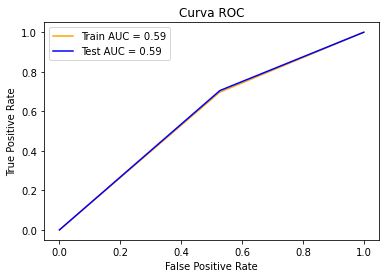

              precision    recall  f1-score   support

           0       0.55      0.48      0.51      1131
           1       0.56      0.63      0.59      1173

    accuracy                           0.56      2304
   macro avg       0.56      0.55      0.55      2304
weighted avg       0.56      0.56      0.55      2304



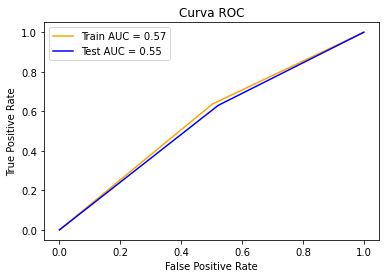

In [292]:
from sklearn.model_selection import KFold
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
random.seed(42)

X = X_resampled
y = y_resampled

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = [SVC(), GaussianNB(), KNeighborsClassifier(), 
          GradientBoostingClassifier(), AdaBoostClassifier(), MLPClassifier()]

for model in models:
    print("Model:", type(model).__name__)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
        report = classification_report(y_test, y_pred)

        # Imprimir el informe de clasificación
        print(report)
        
        y_train_pred = model.predict(X_train)
        mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)
    print("="*50)

SVC: Buen recall pero un score y una precision muy mala. Seguramente este poniendo todo a 1. <br>
GaussianNB: Igual que la anterior pero con peor recall incluso. <br>
KneighborsClassifier: Scores cercanos a 0.78, precisiones alrededor de 0.77 y recalls sobre 0.84. El RandomForestClassifier da mejores resultados. <br>
GradientBoostingClassifier: Scores sobre 0.7, precisiones sobre 0.69 y recalls sobre 0.76. Peor que RandomForestClassifier. <br>
AdaBoostClassifier: Todo por debajo de 0.7. <br>
MLPClassifier: Resultados variados pero peores que otros en general.

RandomForestClassifier es el que mejor va para estos datos equilibrados.

----------------------------------------------------------------------------------------------------------------------------

Repetiré aqui el kcross-validation pero eliminando muestras de la clase mayoritaria en vez de añadir de la minoritaria:

En este caso TomekLinks elimina los datos de clase 0 muy cercanos a datos clase 1, por lo que no puedo predecir la proporcion final de los datos etiquetados con 0 y los de 1:

In [293]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()

df = pd.read_csv('datosEntrenables20230131-full.csv')
parcelasAQuitar = df.loc[df['estacion'] == 'not inialized']['parcela'].unique()
df = df[~df['parcela'].isin(parcelasAQuitar)]
df = df.drop(columns=['Unnamed: 0','precSum3','estacion'])
df = quitarDatosMalos(df)
X_resampled,y_resampled = tl.fit_resample(df.drop(columns=['recogido','parcela','dia']), df['recogido'])
X_resampled = anyadirRelacionesParametros(X_resampled, ['tmed','prec','ndvi'])
anyadirUnos(X_resampled)

Tenemos 7173 filas de datos las cuales 1920 son de la clase 1

Voy a probar con distintos tipos de modelos simples:

Model: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1043
           1       0.78      0.42      0.55       392

    accuracy                           0.81      1435
   macro avg       0.80      0.69      0.71      1435
weighted avg       0.81      0.81      0.79      1435



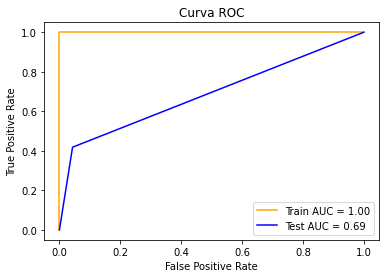

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1067
           1       0.81      0.38      0.52       368

    accuracy                           0.82      1435
   macro avg       0.81      0.68      0.70      1435
weighted avg       0.82      0.82      0.79      1435



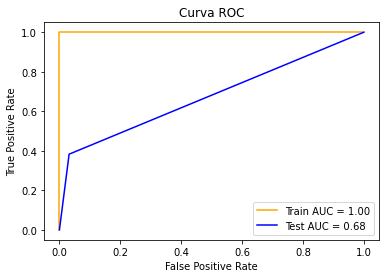

              precision    recall  f1-score   support

           0       0.81      0.95      0.88      1052
           1       0.74      0.39      0.51       383

    accuracy                           0.80      1435
   macro avg       0.78      0.67      0.69      1435
weighted avg       0.79      0.80      0.78      1435



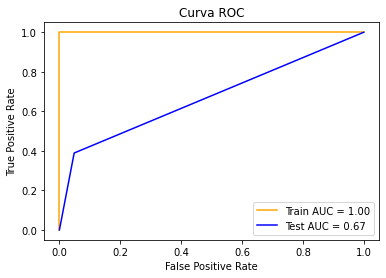

              precision    recall  f1-score   support

           0       0.81      0.95      0.88      1041
           1       0.78      0.42      0.55       393

    accuracy                           0.81      1434
   macro avg       0.80      0.69      0.71      1434
weighted avg       0.80      0.81      0.79      1434



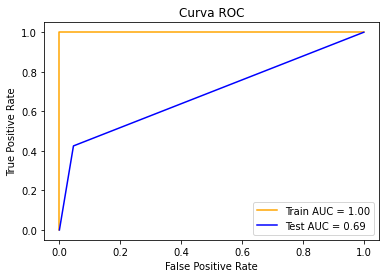

              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1050
           1       0.77      0.38      0.51       384

    accuracy                           0.80      1434
   macro avg       0.79      0.67      0.69      1434
weighted avg       0.80      0.80      0.78      1434



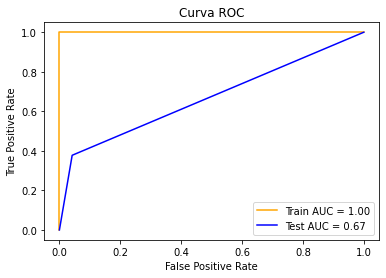

Model: SVC


D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1043
           1       0.00      0.00      0.00       392

    accuracy                           0.73      1435
   macro avg       0.36      0.50      0.42      1435
weighted avg       0.53      0.73      0.61      1435



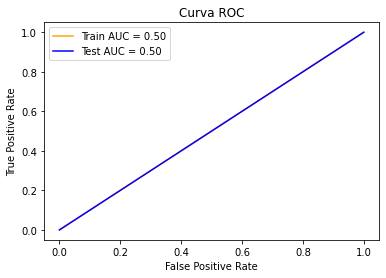

D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1067
           1       0.00      0.00      0.00       368

    accuracy                           0.74      1435
   macro avg       0.37      0.50      0.43      1435
weighted avg       0.55      0.74      0.63      1435



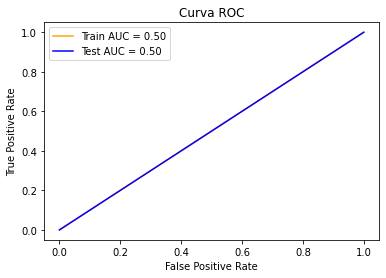

D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1052
           1       0.00      0.00      0.00       383

    accuracy                           0.73      1435
   macro avg       0.37      0.50      0.42      1435
weighted avg       0.54      0.73      0.62      1435



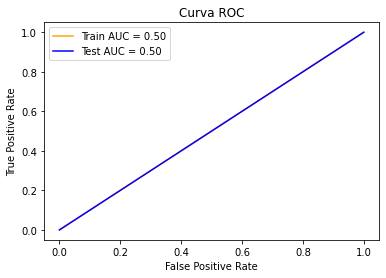

D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1041
           1       0.00      0.00      0.00       393

    accuracy                           0.73      1434
   macro avg       0.36      0.50      0.42      1434
weighted avg       0.53      0.73      0.61      1434



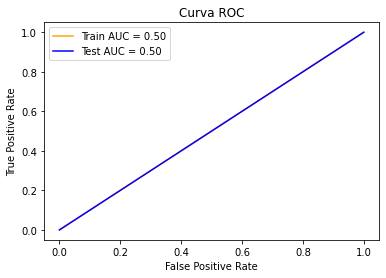

D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1050
           1       0.00      0.00      0.00       384

    accuracy                           0.73      1434
   macro avg       0.37      0.50      0.42      1434
weighted avg       0.54      0.73      0.62      1434



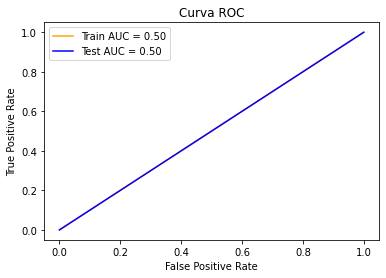

Model: GaussianNB
              precision    recall  f1-score   support

           0       0.79      0.42      0.55      1043
           1       0.31      0.70      0.43       392

    accuracy                           0.49      1435
   macro avg       0.55      0.56      0.49      1435
weighted avg       0.66      0.49      0.51      1435



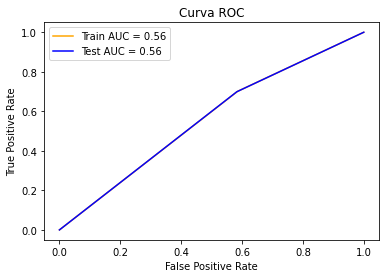

              precision    recall  f1-score   support

           0       0.80      0.40      0.53      1067
           1       0.29      0.71      0.41       368

    accuracy                           0.48      1435
   macro avg       0.54      0.55      0.47      1435
weighted avg       0.67      0.48      0.50      1435



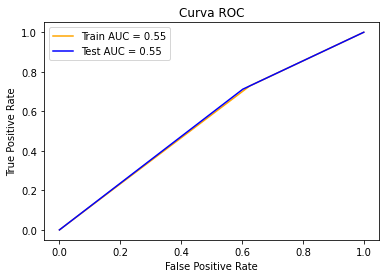

              precision    recall  f1-score   support

           0       0.81      0.42      0.56      1052
           1       0.31      0.72      0.44       383

    accuracy                           0.50      1435
   macro avg       0.56      0.57      0.50      1435
weighted avg       0.68      0.50      0.52      1435



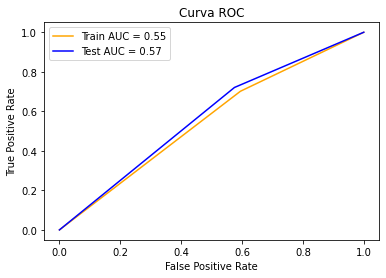

              precision    recall  f1-score   support

           0       0.77      0.36      0.49      1041
           1       0.30      0.72      0.42       393

    accuracy                           0.46      1434
   macro avg       0.54      0.54      0.46      1434
weighted avg       0.64      0.46      0.47      1434



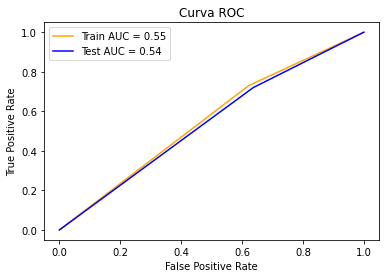

              precision    recall  f1-score   support

           0       0.77      0.38      0.51      1050
           1       0.29      0.70      0.41       384

    accuracy                           0.46      1434
   macro avg       0.53      0.54      0.46      1434
weighted avg       0.64      0.46      0.48      1434



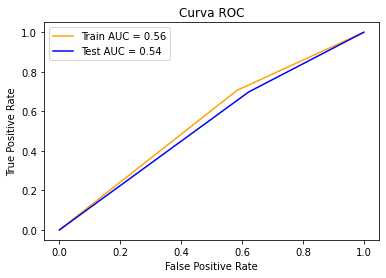

Model: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1043
           1       0.59      0.50      0.54       392

    accuracy                           0.77      1435
   macro avg       0.71      0.69      0.69      1435
weighted avg       0.76      0.77      0.76      1435



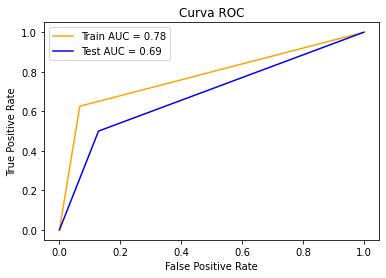

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1067
           1       0.57      0.46      0.51       368

    accuracy                           0.77      1435
   macro avg       0.70      0.67      0.68      1435
weighted avg       0.76      0.77      0.76      1435



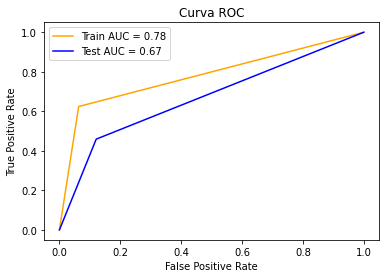

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1052
           1       0.58      0.47      0.52       383

    accuracy                           0.77      1435
   macro avg       0.70      0.67      0.68      1435
weighted avg       0.76      0.77      0.76      1435



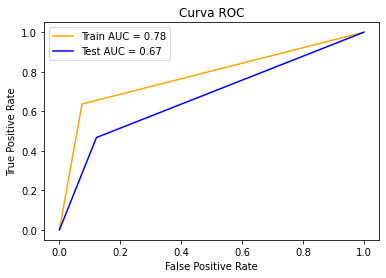

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1041
           1       0.65      0.48      0.55       393

    accuracy                           0.79      1434
   macro avg       0.74      0.69      0.71      1434
weighted avg       0.77      0.79      0.78      1434



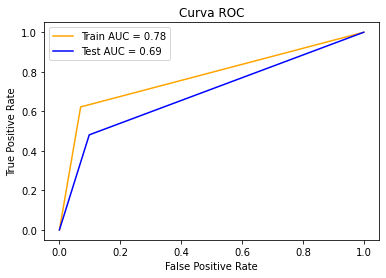

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1050
           1       0.64      0.48      0.55       384

    accuracy                           0.79      1434
   macro avg       0.73      0.69      0.71      1434
weighted avg       0.78      0.79      0.78      1434



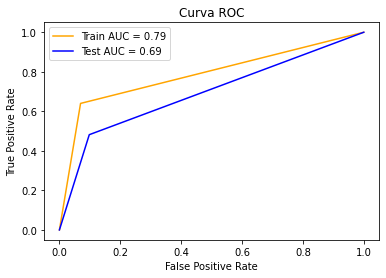

Model: GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.74      0.99      0.85      1043
           1       0.72      0.09      0.15       392

    accuracy                           0.74      1435
   macro avg       0.73      0.54      0.50      1435
weighted avg       0.74      0.74      0.66      1435



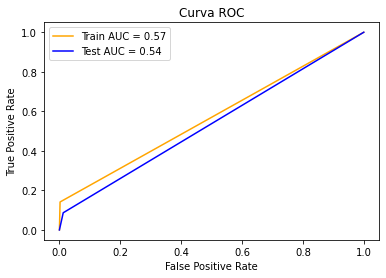

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1067
           1       0.74      0.11      0.19       368

    accuracy                           0.76      1435
   macro avg       0.75      0.55      0.52      1435
weighted avg       0.76      0.76      0.69      1435



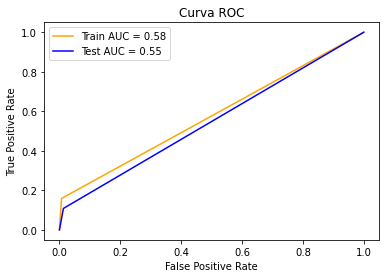

              precision    recall  f1-score   support

           0       0.75      0.98      0.85      1052
           1       0.67      0.08      0.15       383

    accuracy                           0.74      1435
   macro avg       0.71      0.53      0.50      1435
weighted avg       0.73      0.74      0.66      1435



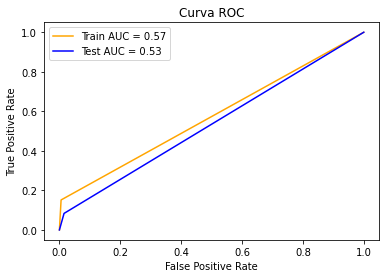

              precision    recall  f1-score   support

           0       0.74      0.99      0.85      1041
           1       0.80      0.08      0.15       393

    accuracy                           0.74      1434
   macro avg       0.77      0.54      0.50      1434
weighted avg       0.76      0.74      0.66      1434



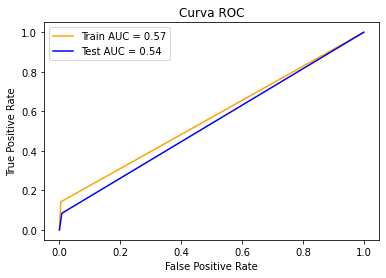

              precision    recall  f1-score   support

           0       0.75      0.99      0.86      1050
           1       0.78      0.12      0.21       384

    accuracy                           0.76      1434
   macro avg       0.77      0.55      0.53      1434
weighted avg       0.76      0.76      0.68      1434



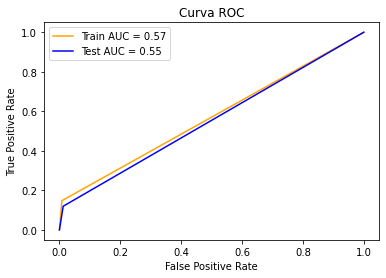

Model: AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1043
           1       0.64      0.02      0.04       392

    accuracy                           0.73      1435
   macro avg       0.69      0.51      0.44      1435
weighted avg       0.71      0.73      0.62      1435



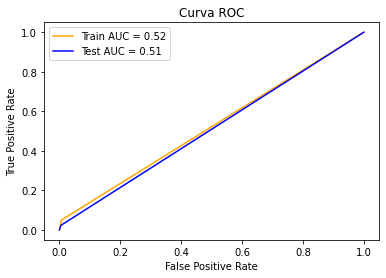

              precision    recall  f1-score   support

           0       0.75      0.99      0.86      1067
           1       0.71      0.05      0.10       368

    accuracy                           0.75      1435
   macro avg       0.73      0.52      0.48      1435
weighted avg       0.74      0.75      0.66      1435



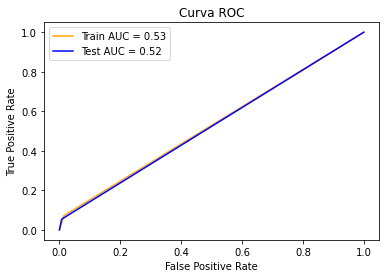

              precision    recall  f1-score   support

           0       0.74      0.98      0.84      1052
           1       0.47      0.04      0.08       383

    accuracy                           0.73      1435
   macro avg       0.60      0.51      0.46      1435
weighted avg       0.67      0.73      0.64      1435



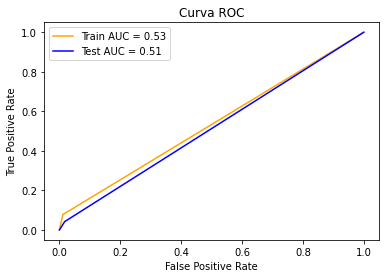

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1041
           1       0.57      0.04      0.08       393

    accuracy                           0.73      1434
   macro avg       0.65      0.51      0.46      1434
weighted avg       0.69      0.73      0.63      1434



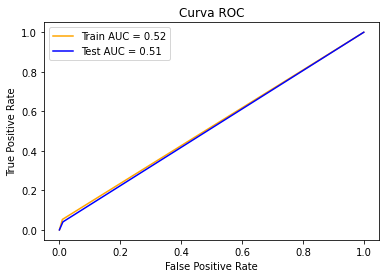

              precision    recall  f1-score   support

           0       0.74      0.98      0.84      1050
           1       0.55      0.05      0.10       384

    accuracy                           0.74      1434
   macro avg       0.65      0.52      0.47      1434
weighted avg       0.69      0.74      0.65      1434



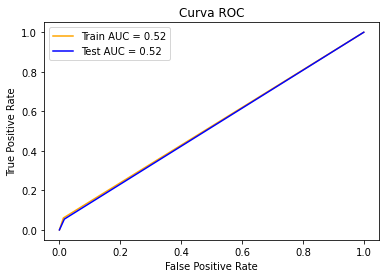

Model: MLPClassifier
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1043
           1       1.00      0.00      0.01       392

    accuracy                           0.73      1435
   macro avg       0.86      0.50      0.42      1435
weighted avg       0.80      0.73      0.61      1435



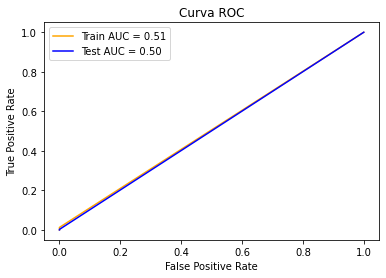

D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1067
           1       0.00      0.00      0.00       368

    accuracy                           0.74      1435
   macro avg       0.37      0.50      0.43      1435
weighted avg       0.55      0.74      0.63      1435



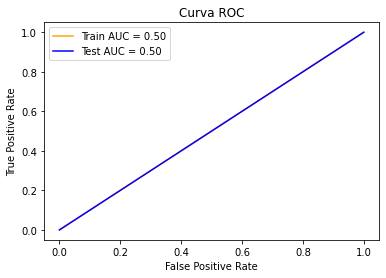

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1052
           1       0.33      0.01      0.02       383

    accuracy                           0.73      1435
   macro avg       0.53      0.50      0.43      1435
weighted avg       0.63      0.73      0.62      1435



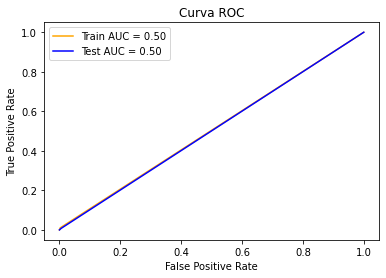

              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1041
           1       0.75      0.01      0.02       393

    accuracy                           0.73      1434
   macro avg       0.74      0.50      0.43      1434
weighted avg       0.73      0.73      0.62      1434



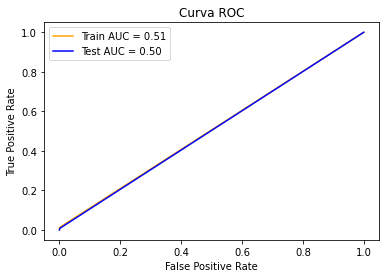

D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Uni\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1050
           1       0.00      0.00      0.00       384

    accuracy                           0.73      1434
   macro avg       0.37      0.50      0.42      1434
weighted avg       0.54      0.73      0.62      1434



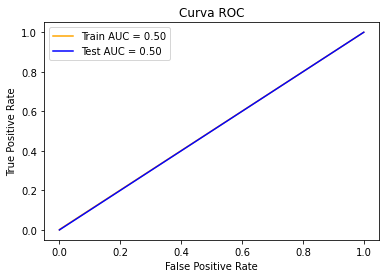

In [294]:
from sklearn.model_selection import KFold
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
random.seed(42)

X = X_resampled
y = y_resampled

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = [RandomForestClassifier(), SVC(), GaussianNB(), KNeighborsClassifier(), 
          GradientBoostingClassifier(), AdaBoostClassifier(), MLPClassifier()]

for model in models:
    print("Model:", type(model).__name__)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
        report = classification_report(y_test, y_pred)

        # Imprimir el informe de clasificación
        print(report)
        
        y_train_pred = model.predict(X_train)
        mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)
        
    print("="*50)

Resultados mucho peores que para la adicion de datos de la clase minoritaria sobretodo en recall.

Voy a probar con otra manera de eliminar oversampling por si acaso, pero tiene pinta que no va a funcionar tan bien como la adicion de datos con undersampling.

In [295]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

df = pd.read_csv('datosEntrenables20230131-full.csv')
parcelasAQuitar = df.loc[df['estacion'] == 'not inialized']['parcela'].unique()
df = df[~df['parcela'].isin(parcelasAQuitar)]
df = df.drop(columns=['Unnamed: 0','precSum3','estacion'])
df = quitarDatosMalos(df)
X_resampled,y_resampled = rus.fit_resample(df.drop(columns=['recogido','parcela','dia']), df['recogido'])
X_resampled = anyadirRelacionesParametros(X_resampled, ['tmed','prec','ndvi'])
anyadirUnos(X_resampled)

RandomUnderSampler ha eliminado datos de la clase mayoritaria hasta igualar el numero de muestras con la clase mayoritaria de forma aleatoria

Model: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       406
           1       0.72      0.73      0.72       362

    accuracy                           0.74       768
   macro avg       0.74      0.74      0.74       768
weighted avg       0.74      0.74      0.74       768



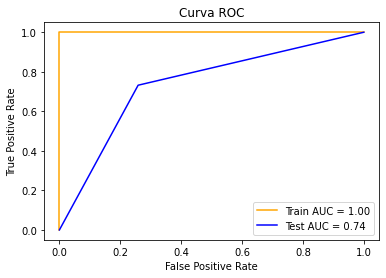

              precision    recall  f1-score   support

           0       0.77      0.73      0.75       385
           1       0.74      0.78      0.76       383

    accuracy                           0.75       768
   macro avg       0.75      0.75      0.75       768
weighted avg       0.75      0.75      0.75       768



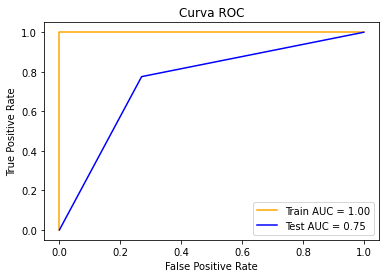

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       375
           1       0.72      0.73      0.72       393

    accuracy                           0.72       768
   macro avg       0.72      0.72      0.72       768
weighted avg       0.72      0.72      0.72       768



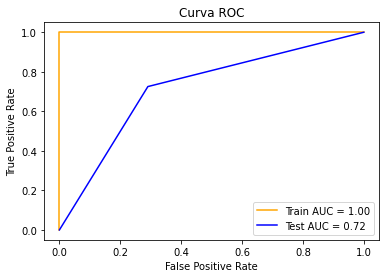

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       376
           1       0.75      0.78      0.76       392

    accuracy                           0.75       768
   macro avg       0.75      0.75      0.75       768
weighted avg       0.75      0.75      0.75       768



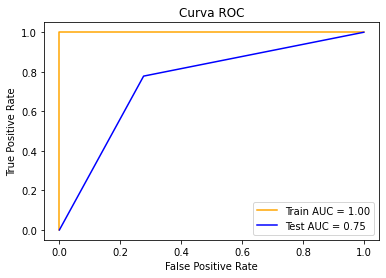

              precision    recall  f1-score   support

           0       0.74      0.70      0.72       378
           1       0.72      0.76      0.74       390

    accuracy                           0.73       768
   macro avg       0.73      0.73      0.73       768
weighted avg       0.73      0.73      0.73       768



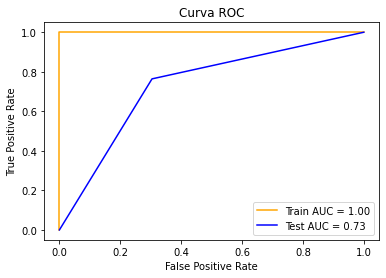

Model: SVC
              precision    recall  f1-score   support

           0       0.68      0.17      0.28       406
           1       0.49      0.91      0.64       362

    accuracy                           0.52       768
   macro avg       0.59      0.54      0.46       768
weighted avg       0.59      0.52      0.45       768



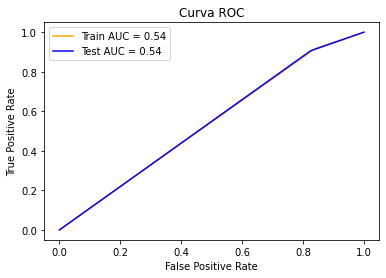

              precision    recall  f1-score   support

           0       0.67      0.15      0.24       385
           1       0.52      0.93      0.67       383

    accuracy                           0.54       768
   macro avg       0.59      0.54      0.45       768
weighted avg       0.59      0.54      0.45       768



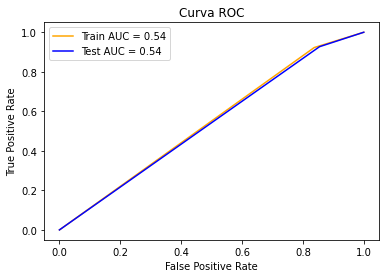

              precision    recall  f1-score   support

           0       0.55      0.15      0.23       375
           1       0.52      0.89      0.66       393

    accuracy                           0.52       768
   macro avg       0.54      0.52      0.44       768
weighted avg       0.54      0.52      0.45       768



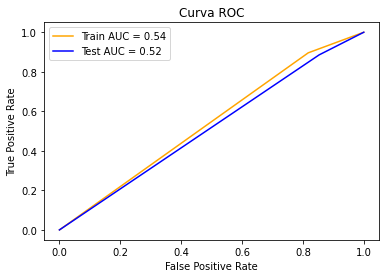

              precision    recall  f1-score   support

           0       0.61      0.16      0.26       376
           1       0.53      0.90      0.67       392

    accuracy                           0.54       768
   macro avg       0.57      0.53      0.46       768
weighted avg       0.57      0.54      0.47       768



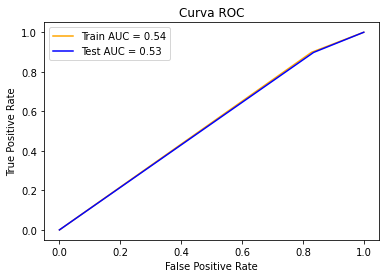

              precision    recall  f1-score   support

           0       0.60      0.19      0.29       378
           1       0.53      0.88      0.66       390

    accuracy                           0.54       768
   macro avg       0.57      0.54      0.48       768
weighted avg       0.57      0.54      0.48       768



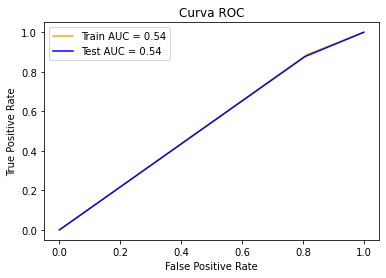

Model: GaussianNB
              precision    recall  f1-score   support

           0       0.63      0.22      0.32       406
           1       0.49      0.85      0.63       362

    accuracy                           0.52       768
   macro avg       0.56      0.54      0.48       768
weighted avg       0.56      0.52      0.47       768



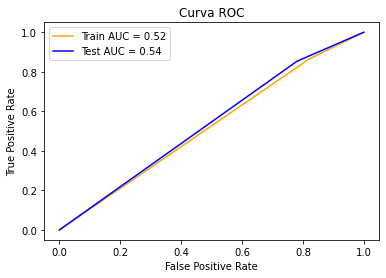

              precision    recall  f1-score   support

           0       0.61      0.21      0.32       385
           1       0.52      0.86      0.65       383

    accuracy                           0.54       768
   macro avg       0.56      0.54      0.48       768
weighted avg       0.56      0.54      0.48       768



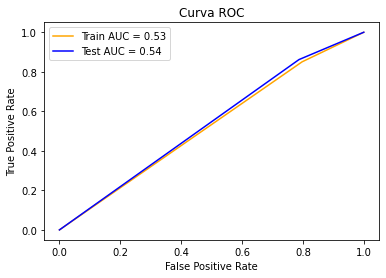

              precision    recall  f1-score   support

           0       0.50      0.18      0.27       375
           1       0.52      0.83      0.64       393

    accuracy                           0.51       768
   macro avg       0.51      0.51      0.45       768
weighted avg       0.51      0.51      0.46       768



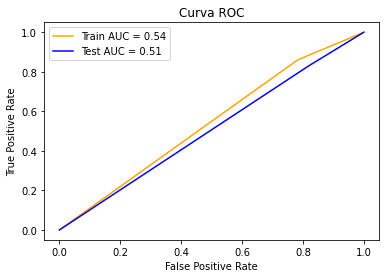

              precision    recall  f1-score   support

           0       0.56      0.17      0.26       376
           1       0.52      0.87      0.65       392

    accuracy                           0.53       768
   macro avg       0.54      0.52      0.46       768
weighted avg       0.54      0.53      0.46       768



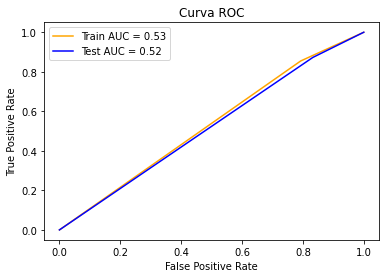

              precision    recall  f1-score   support

           0       0.59      0.22      0.32       378
           1       0.53      0.85      0.65       390

    accuracy                           0.54       768
   macro avg       0.56      0.54      0.49       768
weighted avg       0.56      0.54      0.49       768



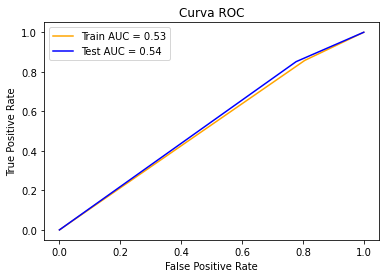

Model: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.73      0.60      0.66       406
           1       0.62      0.75      0.68       362

    accuracy                           0.67       768
   macro avg       0.68      0.67      0.67       768
weighted avg       0.68      0.67      0.67       768



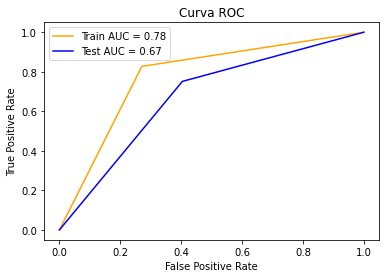

              precision    recall  f1-score   support

           0       0.70      0.61      0.65       385
           1       0.66      0.74      0.69       383

    accuracy                           0.68       768
   macro avg       0.68      0.68      0.67       768
weighted avg       0.68      0.68      0.67       768



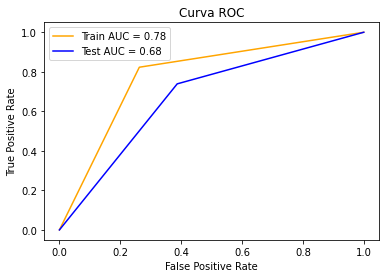

              precision    recall  f1-score   support

           0       0.69      0.59      0.64       375
           1       0.66      0.75      0.70       393

    accuracy                           0.67       768
   macro avg       0.67      0.67      0.67       768
weighted avg       0.67      0.67      0.67       768



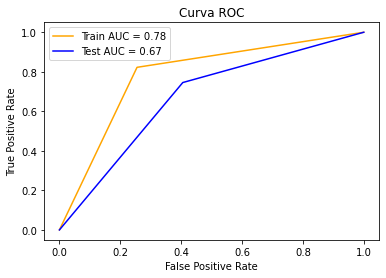

              precision    recall  f1-score   support

           0       0.63      0.63      0.63       376
           1       0.64      0.65      0.64       392

    accuracy                           0.64       768
   macro avg       0.64      0.64      0.64       768
weighted avg       0.64      0.64      0.64       768



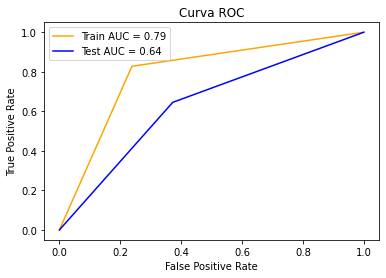

              precision    recall  f1-score   support

           0       0.67      0.62      0.65       378
           1       0.66      0.71      0.68       390

    accuracy                           0.66       768
   macro avg       0.66      0.66      0.66       768
weighted avg       0.66      0.66      0.66       768



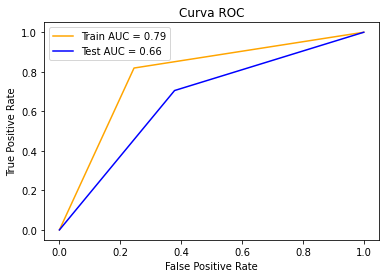

Model: GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.74      0.61      0.66       406
           1       0.63      0.76      0.69       362

    accuracy                           0.68       768
   macro avg       0.68      0.68      0.68       768
weighted avg       0.69      0.68      0.68       768



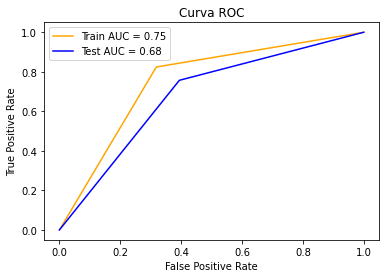

              precision    recall  f1-score   support

           0       0.70      0.56      0.62       385
           1       0.63      0.76      0.69       383

    accuracy                           0.66       768
   macro avg       0.67      0.66      0.66       768
weighted avg       0.67      0.66      0.66       768



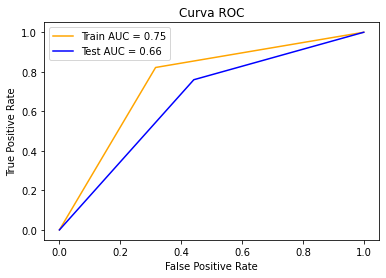

              precision    recall  f1-score   support

           0       0.63      0.58      0.60       375
           1       0.63      0.68      0.65       393

    accuracy                           0.63       768
   macro avg       0.63      0.63      0.63       768
weighted avg       0.63      0.63      0.63       768



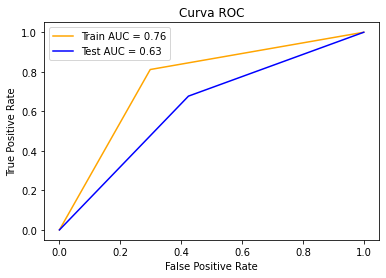

              precision    recall  f1-score   support

           0       0.65      0.64      0.64       376
           1       0.66      0.67      0.66       392

    accuracy                           0.65       768
   macro avg       0.65      0.65      0.65       768
weighted avg       0.65      0.65      0.65       768



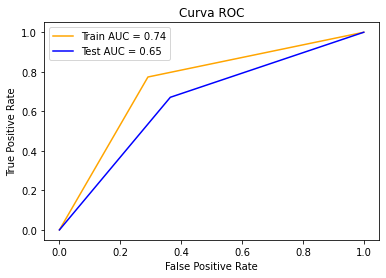

              precision    recall  f1-score   support

           0       0.63      0.60      0.62       378
           1       0.63      0.66      0.64       390

    accuracy                           0.63       768
   macro avg       0.63      0.63      0.63       768
weighted avg       0.63      0.63      0.63       768



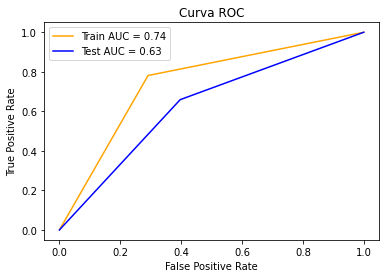

Model: AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.63      0.56      0.59       406
           1       0.56      0.63      0.59       362

    accuracy                           0.59       768
   macro avg       0.60      0.60      0.59       768
weighted avg       0.60      0.59      0.59       768



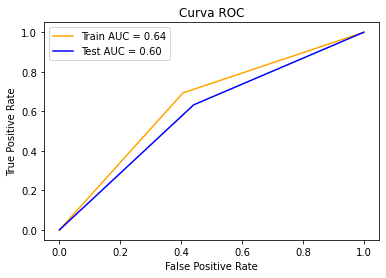

              precision    recall  f1-score   support

           0       0.63      0.50      0.55       385
           1       0.58      0.70      0.64       383

    accuracy                           0.60       768
   macro avg       0.61      0.60      0.60       768
weighted avg       0.61      0.60      0.60       768



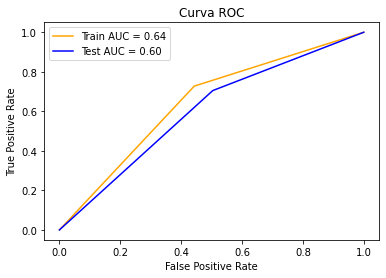

              precision    recall  f1-score   support

           0       0.58      0.55      0.56       375
           1       0.59      0.61      0.60       393

    accuracy                           0.58       768
   macro avg       0.58      0.58      0.58       768
weighted avg       0.58      0.58      0.58       768



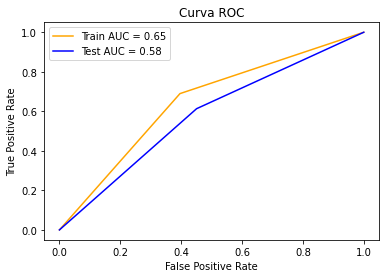

              precision    recall  f1-score   support

           0       0.61      0.55      0.58       376
           1       0.60      0.66      0.63       392

    accuracy                           0.60       768
   macro avg       0.60      0.60      0.60       768
weighted avg       0.60      0.60      0.60       768



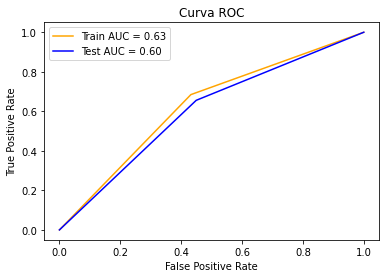

              precision    recall  f1-score   support

           0       0.59      0.52      0.55       378
           1       0.58      0.65      0.62       390

    accuracy                           0.59       768
   macro avg       0.59      0.59      0.58       768
weighted avg       0.59      0.59      0.59       768



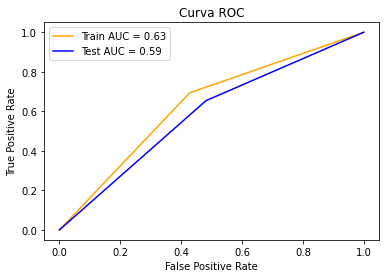

Model: MLPClassifier
              precision    recall  f1-score   support

           0       0.62      0.59      0.60       406
           1       0.56      0.59      0.58       362

    accuracy                           0.59       768
   macro avg       0.59      0.59      0.59       768
weighted avg       0.59      0.59      0.59       768



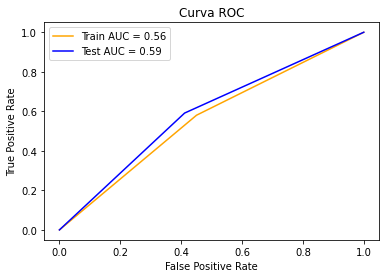

              precision    recall  f1-score   support

           0       0.59      0.36      0.45       385
           1       0.54      0.75      0.63       383

    accuracy                           0.55       768
   macro avg       0.57      0.56      0.54       768
weighted avg       0.57      0.55      0.54       768



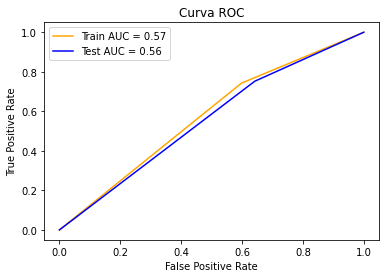

              precision    recall  f1-score   support

           0       0.57      0.38      0.45       375
           1       0.55      0.73      0.63       393

    accuracy                           0.56       768
   macro avg       0.56      0.55      0.54       768
weighted avg       0.56      0.56      0.54       768



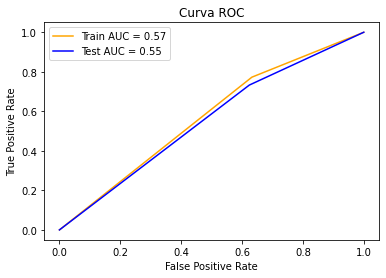

              precision    recall  f1-score   support

           0       0.61      0.28      0.39       376
           1       0.55      0.83      0.66       392

    accuracy                           0.56       768
   macro avg       0.58      0.56      0.52       768
weighted avg       0.58      0.56      0.53       768



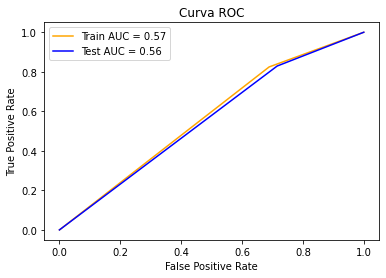

              precision    recall  f1-score   support

           0       0.53      0.69      0.60       378
           1       0.58      0.41      0.48       390

    accuracy                           0.55       768
   macro avg       0.56      0.55      0.54       768
weighted avg       0.56      0.55      0.54       768



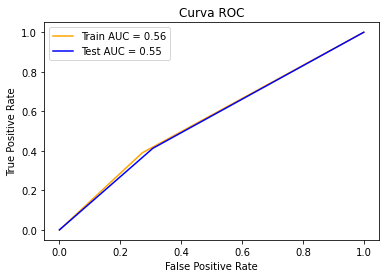

In [296]:
from sklearn.model_selection import KFold
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
random.seed(42)

X = X_resampled
y = y_resampled

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = [RandomForestClassifier(), SVC(), GaussianNB(), KNeighborsClassifier(), 
          GradientBoostingClassifier(), AdaBoostClassifier(), MLPClassifier()]

for model in models:
    print("Model:", type(model).__name__)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
        report = classification_report(y_test, y_pred)

        # Imprimir el informe de clasificación
        print(report)
        
        y_train_pred = model.predict(X_train)
        mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)
    print("="*50)

Sigue sin haber un resultado tan bueno como la primera prueba de RandomForestClassification

-----------------------------------------------------------------------------------------------------------------------------

Como el añadir muestras de la clase minoritaria es lo que mejor va, voy a repetir las pruebas anteriores pero normalizando (entre -1 y 1 ya que las pendientes pueden ser valores negativos) los valores de entrenamiento:

In [297]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Normalizar X y y
scaler = MinMaxScaler(feature_range=(-1, 1))

smote = SMOTE(sampling_strategy=1)

df = pd.read_csv('datosEntrenables20230131-full.csv')
parcelasAQuitar = df.loc[df['estacion'] == 'not inialized']['parcela'].unique()
df = df[~df['parcela'].isin(parcelasAQuitar)]
df = df.drop(columns=['Unnamed: 0','precSum3','estacion'])
df = quitarDatosMalos(df)
X_resampled,y_resampled = smote.fit_resample(df.drop(columns=['recogido','parcela','dia']), df['recogido'])
X_norm = scaler.fit_transform(X_resampled)
X_norm_df = pd.DataFrame(X_norm, columns=df.drop(columns=['recogido','parcela','dia']).columns)
X_norm_df = anyadirRelacionesParametros(X_norm_df, ['tmed','prec','ndvi'])
anyadirUnos(X_norm_df)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1138
           1       0.83      0.81      0.82      1166

    accuracy                           0.82      2304
   macro avg       0.82      0.82      0.82      2304
weighted avg       0.82      0.82      0.82      2304



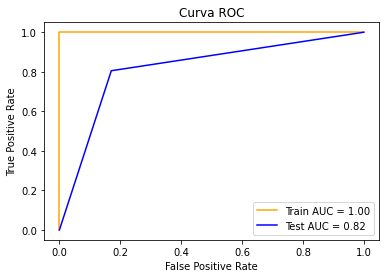

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1143
           1       0.81      0.82      0.82      1161

    accuracy                           0.81      2304
   macro avg       0.81      0.81      0.81      2304
weighted avg       0.81      0.81      0.81      2304



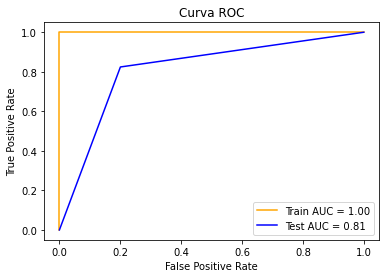

              precision    recall  f1-score   support

           0       0.85      0.76      0.80      1180
           1       0.77      0.86      0.81      1124

    accuracy                           0.81      2304
   macro avg       0.81      0.81      0.81      2304
weighted avg       0.81      0.81      0.81      2304



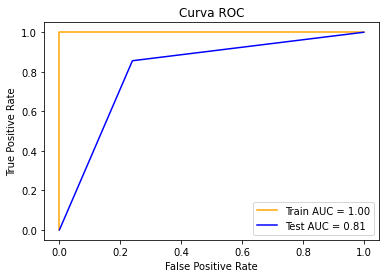

              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1168
           1       0.79      0.82      0.80      1136

    accuracy                           0.80      2304
   macro avg       0.80      0.80      0.80      2304
weighted avg       0.80      0.80      0.80      2304



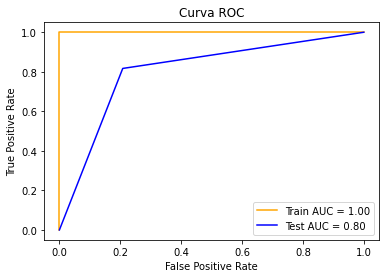

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1131
           1       0.81      0.85      0.83      1173

    accuracy                           0.82      2304
   macro avg       0.82      0.82      0.82      2304
weighted avg       0.82      0.82      0.82      2304



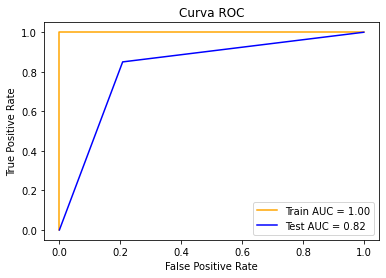

In [298]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
import random
random.seed(42)
X = X_norm_df
y = y_resampled

kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier()

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
    report = classification_report(y_test, y_pred)

    # Imprimir el informe de clasificación
    print(report)

    y_train_pred = model.predict(X_train)
    mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)

Ahora lo mismo pero con la normalizacion entre 0 y 1

In [299]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Normalizar X y y
scaler = MinMaxScaler(feature_range=(0, 1))

smote = SMOTE(sampling_strategy=1)

df = pd.read_csv('datosEntrenables20230131-full.csv')
parcelasAQuitar = df.loc[df['estacion'] == 'not inialized']['parcela'].unique()
df = df[~df['parcela'].isin(parcelasAQuitar)]
df = df.drop(columns=['Unnamed: 0','precSum3','estacion'])
df = quitarDatosMalos(df)
X_resampled,y_resampled = smote.fit_resample(df.drop(columns=['recogido','parcela','dia']), df['recogido'])
X_norm = scaler.fit_transform(X_resampled)
X_norm_df = pd.DataFrame(X_norm, columns=df.drop(columns=['recogido','parcela','dia']).columns)
X_norm_df = anyadirRelacionesParametros(X_norm_df, ['tmed','prec','ndvi'])
anyadirUnos(X_norm_df)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1138
           1       0.83      0.85      0.84      1166

    accuracy                           0.83      2304
   macro avg       0.83      0.83      0.83      2304
weighted avg       0.83      0.83      0.83      2304



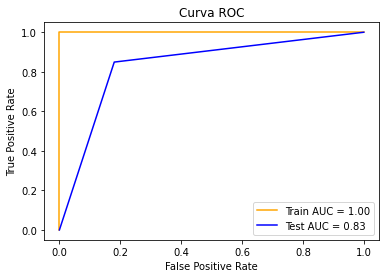

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1143
           1       0.81      0.85      0.83      1161

    accuracy                           0.83      2304
   macro avg       0.83      0.82      0.82      2304
weighted avg       0.83      0.83      0.82      2304



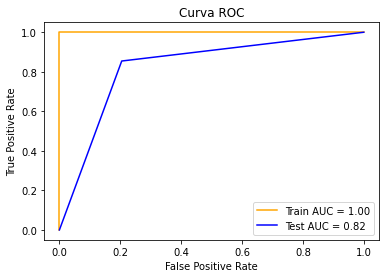

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1180
           1       0.79      0.85      0.82      1124

    accuracy                           0.81      2304
   macro avg       0.81      0.81      0.81      2304
weighted avg       0.82      0.81      0.81      2304



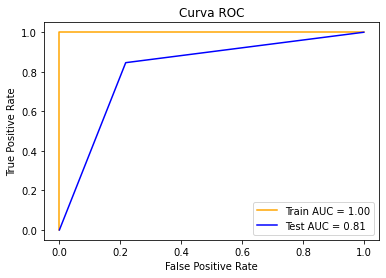

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1168
           1       0.81      0.84      0.82      1136

    accuracy                           0.82      2304
   macro avg       0.82      0.82      0.82      2304
weighted avg       0.82      0.82      0.82      2304



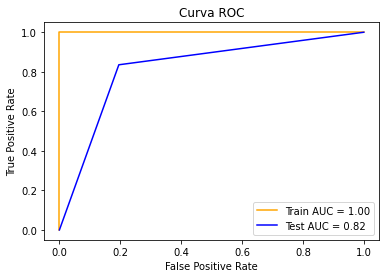

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1131
           1       0.81      0.84      0.83      1173

    accuracy                           0.82      2304
   macro avg       0.82      0.82      0.82      2304
weighted avg       0.82      0.82      0.82      2304



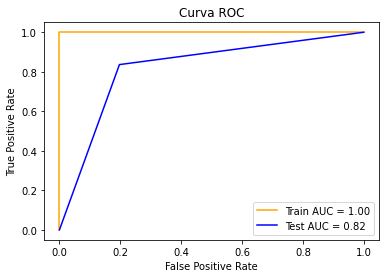

In [300]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
import random
random.seed(42)
X = X_norm_df
y = y_resampled

kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier()

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
    report = classification_report(y_test, y_pred)

    # Imprimir el informe de clasificación
    print(report)
    
    y_train_pred = model.predict(X_train)
    mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)

Diria que funciona mejor con la regularizacion de 0 y 1 ya que los valores maximos de cada metrica se encuentran en esta segunda prueba. De hecho, siguiendo esta logica, es mejor que la primera prueba en la que no se normalizó siquiera.

-----------------------------------------------------------------------------------------------------------------------------

En este punto he probado ya los metodos de under y oversampling, la normalizacion entre -1 y 1 y distintos modelos simples, delos cuales el mejor ha sido RandomForestClassifier.

-----------------------------------------------------------------------------------------------------------------------------

Ahora que veo que funciona mejor el añadir datos de la clase minoritaria voy a preparar en 'TPAyudaMarioEntrenamiento-20230214.ipynb' el entrenamiento con una red neuronal como estaba haciendo hasta ahora pero con estos datos equilibrados y normalizados entre 0 y 1 para ver si se debe a los datos equilibrados o a que la red neuronal era demasiado compleja para este problema:

-----------------------------------------------------------------------------------------------------------------------------

Ahora me faltaria probar distintos algoritmos como Xgboost, Lgbm, RandomForest (este ya lo he probado sin darme cuenta) y Gbm:

Estos algoritmos tienen parametros extra como la profundidad en el caso del RandomForest.

-----------------------------------------------------------------------------------------------------------------------------

XGBOOST:

In [301]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Normalizar X y y
scaler = MinMaxScaler(feature_range=(0, 1))

smote = SMOTE(sampling_strategy=1)

df = pd.read_csv('datosEntrenables20230131-full.csv')
parcelasAQuitar = df.loc[df['estacion'] == 'not inialized']['parcela'].unique()
df = df[~df['parcela'].isin(parcelasAQuitar)]
df = df.drop(columns=['Unnamed: 0','precSum3','estacion'])
df = quitarDatosMalos(df)
X_resampled,y_resampled = smote.fit_resample(df.drop(columns=['recogido','parcela','dia']), df['recogido'])
X_norm = scaler.fit_transform(X_resampled)
X_norm_df = pd.DataFrame(X_norm, columns=df.drop(columns=['recogido','parcela','dia']).columns)
X_norm_df = anyadirRelacionesParametros(X_norm_df, ['tmed','prec','ndvi'])
anyadirUnos(X_norm_df)

              precision    recall  f1-score   support

           0       0.73      0.63      0.68      1138
           1       0.68      0.78      0.73      1166

    accuracy                           0.70      2304
   macro avg       0.71      0.70      0.70      2304
weighted avg       0.71      0.70      0.70      2304



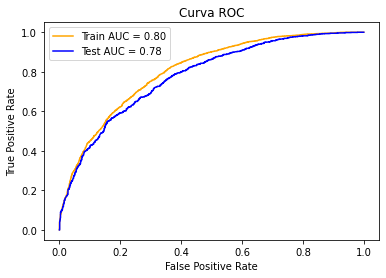

              precision    recall  f1-score   support

           0       0.74      0.59      0.66      1143
           1       0.66      0.79      0.72      1161

    accuracy                           0.69      2304
   macro avg       0.70      0.69      0.69      2304
weighted avg       0.70      0.69      0.69      2304



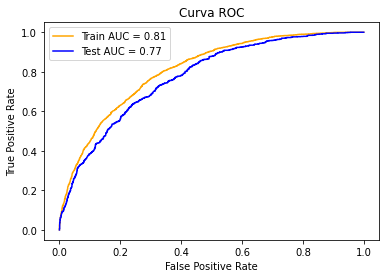

              precision    recall  f1-score   support

           0       0.73      0.58      0.65      1180
           1       0.64      0.78      0.70      1124

    accuracy                           0.68      2304
   macro avg       0.69      0.68      0.68      2304
weighted avg       0.69      0.68      0.68      2304



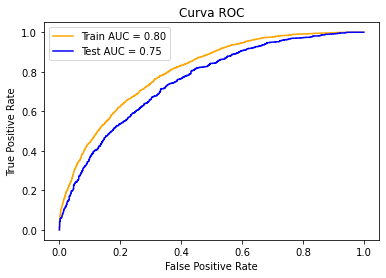

              precision    recall  f1-score   support

           0       0.72      0.62      0.67      1168
           1       0.66      0.75      0.70      1136

    accuracy                           0.69      2304
   macro avg       0.69      0.69      0.69      2304
weighted avg       0.69      0.69      0.69      2304



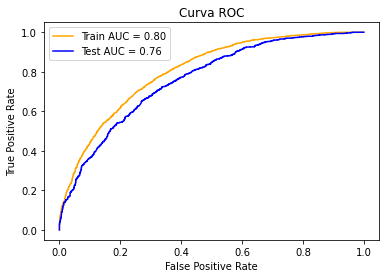

              precision    recall  f1-score   support

           0       0.70      0.63      0.67      1131
           1       0.68      0.74      0.71      1173

    accuracy                           0.69      2304
   macro avg       0.69      0.69      0.69      2304
weighted avg       0.69      0.69      0.69      2304



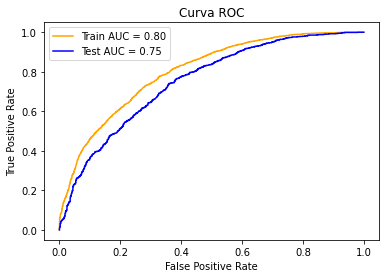

In [307]:
def round_threshold(arr, threshold):
    return np.where(arr >= threshold, np.ceil(arr), np.floor(arr))

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score
import random
from sklearn.metrics import accuracy_score
random.seed(42)

X = X_norm_df
y = y_resampled

params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'error'
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    model = xgb.train(params, dtrain, num_boost_round=100)
    y_pred = model.predict(dtest)
    
    y_pred2 = round_threshold(y_pred, 0.5)
    
    # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
    report = classification_report(y_test, y_pred2)

    # Imprimir el informe de clasificación
    print(report)
    
    y_train_pred = model.predict(dtrain)
    mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)


Resultados no tan buenos como esperaba.

-----------------------------------------------------------------------------------------------------------------------------

LightGBM:

In [308]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Normalizar X y y
scaler = MinMaxScaler(feature_range=(0, 1))

smote = SMOTE(sampling_strategy=1)

df = pd.read_csv('datosEntrenables20230131-full.csv')
parcelasAQuitar = df.loc[df['estacion'] == 'not inialized']['parcela'].unique()
df = df[~df['parcela'].isin(parcelasAQuitar)]
df = df.drop(columns=['Unnamed: 0','precSum3','estacion'])
df = quitarDatosMalos(df)
X_resampled,y_resampled = smote.fit_resample(df.drop(columns=['recogido','parcela','dia']), df['recogido'])
X_norm = scaler.fit_transform(X_resampled)
X_norm_df = pd.DataFrame(X_norm, columns=df.drop(columns=['recogido','parcela','dia']).columns)
X_norm_df = anyadirRelacionesParametros(X_norm_df, ['tmed','prec','ndvi'])
anyadirUnos(X_norm_df)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4594, number of negative: 4622
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 9216, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498481 -> initscore=-0.006076
[LightGBM] [Info] Start training from score -0.006076
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1138
           1       0.79      0.82      0.81      1166

    accuracy                           0.80      2304
   macro avg       0.80      0.80      0.80      2304
weighted avg       0.80      0.80      0.80      2304



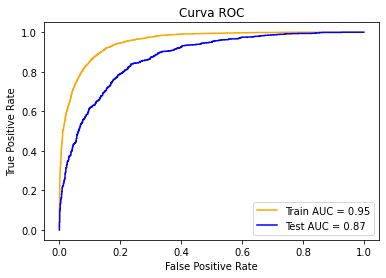

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4599, number of negative: 4617
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 9216, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499023 -> initscore=-0.003906
[LightGBM] [Info] Start training from score -0.003906
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1143
           1       0.79      0.84      0.81      1161

    accuracy                           0.80      2304
   macro avg       0.81      0.80      0.80      2304
weighted avg       0.81      0.80      0.80      2304



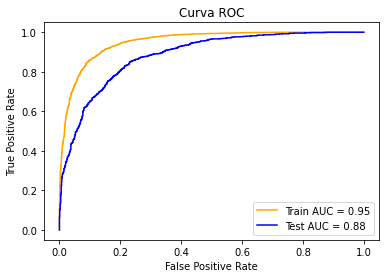

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4636, number of negative: 4580
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 9216, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503038 -> initscore=0.012153
[LightGBM] [Info] Start training from score 0.012153
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      1180
           1       0.75      0.84      0.79      1124

    accuracy                           0.79      2304
   macro avg       0.79      0.79      0.79      2304
weighted avg       0.79      0.79      0.79      2304



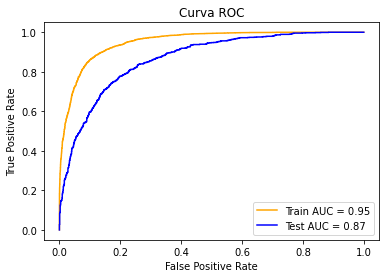

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4624, number of negative: 4592
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 9216, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501736 -> initscore=0.006944
[LightGBM] [Info] Start training from score 0.006944
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1168
           1       0.78      0.84      0.81      1136

    accuracy                           0.80      2304
   macro avg       0.81      0.80      0.80      2304
weighted avg       0.81      0.80      0.80      2304



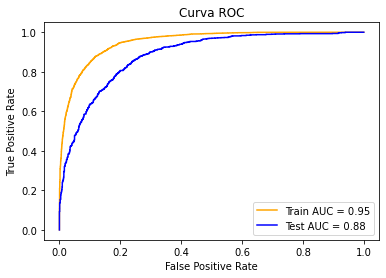

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4587, number of negative: 4629
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 9216, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497721 -> initscore=-0.009115
[LightGBM] [Info] Start training from score -0.009115
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1131
           1       0.78      0.83      0.80      1173

    accuracy                           0.79      2304
   macro avg       0.79      0.79      0.79      2304
weighted avg       0.79      0.79      0.79      2304



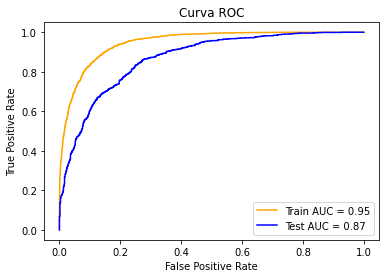

In [309]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score
import random
random.seed(42)

X = X_norm_df
y = y_resampled

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.1
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dtest = lgb.Dataset(X_test, label=y_test)
    
    model = lgb.train(params, dtrain, num_boost_round=100)
    y_pred = model.predict(X_test.values)
    
    y_pred2 = np.round(y_pred)
    
    # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
    report = classification_report(y_test, y_pred2)

    # Imprimir el informe de clasificación
    print(report)
    
    y_train_pred = model.predict(X_train)
    mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)


Mejores resultados que XGBOOST. Los mejores resultados de Test AUC en la curva ROC.

-----------------------------------------------------------------------------------------------------------------------------

RandomForest:

In [310]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Normalizar X y y
scaler = MinMaxScaler(feature_range=(0, 1))

smote = SMOTE(sampling_strategy=1)

df = pd.read_csv('datosEntrenables20230131-full.csv')
parcelasAQuitar = df.loc[df['estacion'] == 'not inialized']['parcela'].unique()
df = df[~df['parcela'].isin(parcelasAQuitar)]
df = df.drop(columns=['Unnamed: 0','precSum3','estacion'])
df = quitarDatosMalos(df)
X_resampled,y_resampled = smote.fit_resample(df.drop(columns=['recogido','parcela','dia']), df['recogido'])
X_norm = scaler.fit_transform(X_resampled)
X_norm_df = pd.DataFrame(X_norm, columns=df.drop(columns=['recogido','parcela','dia']).columns)
X_norm_df = anyadirRelacionesParametros(X_norm_df, ['tmed','prec','ndvi'])
anyadirUnos(X_norm_df)

              precision    recall  f1-score   support

           0       0.63      0.41      0.49      1138
           1       0.57      0.77      0.65      1166

    accuracy                           0.59      2304
   macro avg       0.60      0.59      0.57      2304
weighted avg       0.60      0.59      0.57      2304



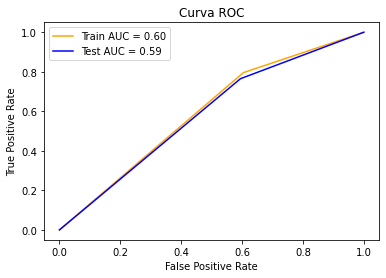

              precision    recall  f1-score   support

           0       0.64      0.39      0.48      1143
           1       0.56      0.78      0.66      1161

    accuracy                           0.59      2304
   macro avg       0.60      0.58      0.57      2304
weighted avg       0.60      0.59      0.57      2304



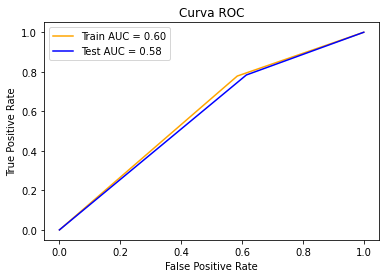

              precision    recall  f1-score   support

           0       0.66      0.42      0.51      1180
           1       0.56      0.78      0.65      1124

    accuracy                           0.59      2304
   macro avg       0.61      0.60      0.58      2304
weighted avg       0.61      0.59      0.58      2304



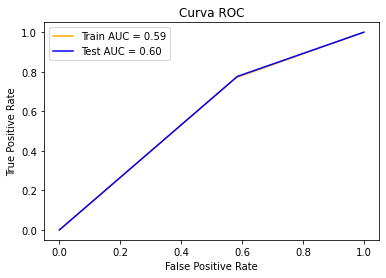

              precision    recall  f1-score   support

           0       0.67      0.42      0.52      1168
           1       0.57      0.78      0.66      1136

    accuracy                           0.60      2304
   macro avg       0.62      0.60      0.59      2304
weighted avg       0.62      0.60      0.59      2304



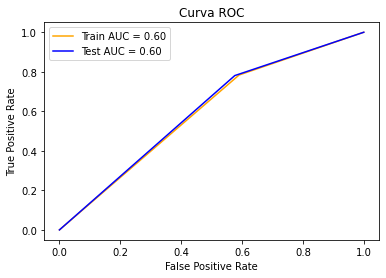

              precision    recall  f1-score   support

           0       0.62      0.43      0.51      1131
           1       0.58      0.75      0.65      1173

    accuracy                           0.59      2304
   macro avg       0.60      0.59      0.58      2304
weighted avg       0.60      0.59      0.58      2304



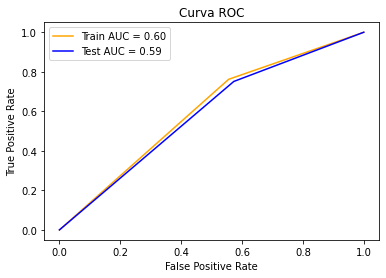

In [311]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score
import random
random.seed(42)

X = X_norm_df
y = y_resampled

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    
    # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
    report = classification_report(y_test, y_pred)

    # Imprimir el informe de clasificación
    print(report)
    
    mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)


Malos resultados.

-----------------------------------------------------------------------------------------------------------------------------

GBM:

In [312]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Normalizar X y y
scaler = MinMaxScaler(feature_range=(0, 1))

smote = SMOTE(sampling_strategy=1)

df = pd.read_csv('datosEntrenables20230131-full.csv')
parcelasAQuitar = df.loc[df['estacion'] == 'not inialized']['parcela'].unique()
df = df[~df['parcela'].isin(parcelasAQuitar)]
df = df.drop(columns=['Unnamed: 0','precSum3','estacion'])
df = quitarDatosMalos(df)
X_resampled,y_resampled = smote.fit_resample(df.drop(columns=['recogido','parcela','dia']), df['recogido'])
X_norm = scaler.fit_transform(X_resampled)
X_norm_df = pd.DataFrame(X_norm, columns=df.drop(columns=['recogido','parcela','dia']).columns)
X_norm_df = anyadirRelacionesParametros(X_norm_df, ['tmed','prec','ndvi'])
anyadirUnos(X_norm_df)

              precision    recall  f1-score   support

           0       0.66      0.59      0.62      1138
           1       0.64      0.70      0.67      1166

    accuracy                           0.65      2304
   macro avg       0.65      0.65      0.65      2304
weighted avg       0.65      0.65      0.65      2304



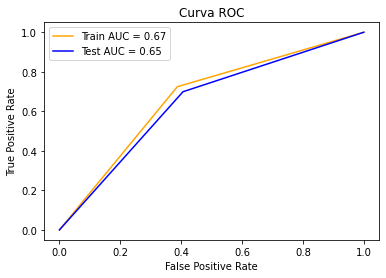

              precision    recall  f1-score   support

           0       0.69      0.59      0.63      1143
           1       0.64      0.74      0.69      1161

    accuracy                           0.66      2304
   macro avg       0.67      0.66      0.66      2304
weighted avg       0.67      0.66      0.66      2304



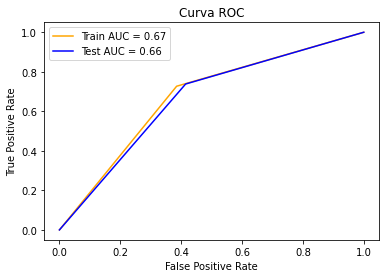

              precision    recall  f1-score   support

           0       0.66      0.57      0.61      1180
           1       0.60      0.69      0.64      1124

    accuracy                           0.63      2304
   macro avg       0.63      0.63      0.63      2304
weighted avg       0.63      0.63      0.63      2304



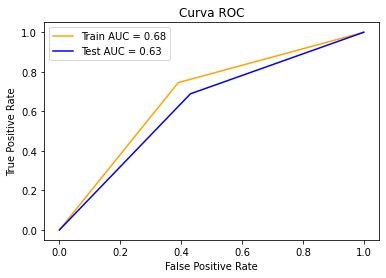

              precision    recall  f1-score   support

           0       0.69      0.58      0.63      1168
           1       0.63      0.73      0.67      1136

    accuracy                           0.65      2304
   macro avg       0.66      0.65      0.65      2304
weighted avg       0.66      0.65      0.65      2304



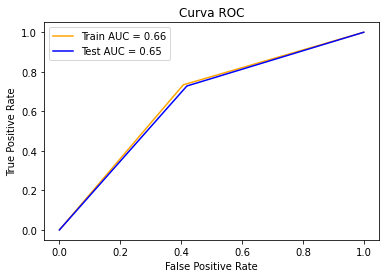

              precision    recall  f1-score   support

           0       0.65      0.61      0.63      1131
           1       0.65      0.69      0.67      1173

    accuracy                           0.65      2304
   macro avg       0.65      0.65      0.65      2304
weighted avg       0.65      0.65      0.65      2304



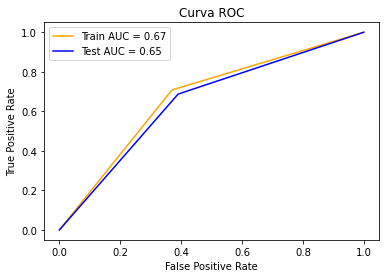

In [313]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

import random
random.seed(42)

X = X_norm_df
y = y_resampled

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
    
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    
    # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
    report = classification_report(y_test, y_pred)

    # Imprimir el informe de clasificación
    print(report)
    
    mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)




Resultados malos.

-----------------------------------------------------------------------------------------------------------------------------

Los mejores resultados han sido los de: